# ==== INTERACTIVE CLUSTERING : COMPUTATION TIME STUDY ====
> ### Stage 3 : Modelize computation time of Interactive Clustering tasks and Plot some figures.

-----

## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at modelize interactive clustering computation time over experiments**.
- Environments are represented by subdirectories in the `/experiments` folder. A full path to an experiment environment is `/experiments/[TASK]/[DATASET]/[ALGORITHM]/`.
- Experiments have to be run and evaluated in order to analyze convergency speed.

Before running, **run the notebook `2_Estimate_computation_time.ipynb` to run each algorithm you have set**.

Then, **go to the notebook `4_Plot_some_figures.ipynb` to create figures on interactive clustering computation time**.

### Description each steps

First of all, **load experiment synthesis CSV file** that have been computed with the last notebook.
- It contains parameters used for each experiment and convergency metric to compare.
- Several parameters are studied depending on the task:
    - _preprocessing_: `dataset_size`, `algorithm_name`;
    - _vectorization_: `dataset_size`, `algorithm_name`;
    - _sampling_: `dataset_size`, `algorithm_name`, `previous_nb_constraints`, `previous_nb_clusters`, `algorithm_nb_to_select`;
    - _clustering_: `dataset_size`, `algorithm_name`, `previous_nb_constraints`, `previous_nb_clusters`.
- Two random effects are used : `dataset_random_seed`, `algorithm_random_seed`.
- One values is modelized with these factors : `time_total`.

Then, for each task :
1. Compute interactions of factors (`1`, `X1`, `X1²`, `X1*X2`, ...)
2. Sort interactions by correlation in order to choose a efficient modelization of computation time
3. Compute GLM to get the modelization parameters
4. Plot modelized computation time

-----

## 1. IMPORT PYTHON DEPENDENCIES

In [1]:
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
import openpyxl
import pandas as pd
from itertools import combinations_with_replacement, permutations
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy import stats as scipystats
import statistics
import statsmodels
import statsmodels.api
import statsmodels.formula.api

In [2]:
statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF(True)

In [3]:
def compute_combinations_of_interactions_of_factors(
    df: pd.DataFrame,
    factors: List[str],
    range_of_powers: List[int] = [0, 1, 2, 3],
    max_power: int = 3,
) -> Tuple[List[Dict[str, str]], pd.DataFrame]:
    """
        Compute combinations of interactions of factors in dataframe.
        
        Args:
            df (pd.DataFrame): Dataframe of results.
            factors (List[str]): Column of dataframe considered as factors.
            range_of_powers (List[int]): Range of power to compute. Defaults to `[0, 1, 2, 3]`.
            max_power (int): Maximum interaction levl, i.e. maximum sum of powers. Defaults to `3`.
        
        Return:
            Tuple[Dict[str, str], pd.DataFrame]: The factors interactions (dictionary) and the updated dataframe of results.
    """

    # The columns computed.
    factors_interactions: Dict[str, str] = {}
    
    # Define combinations of powers.
    for power_combination in combinations_with_replacement(range_of_powers, r=len(factors)):
        
        # Define max combination of powers.
        if sum(power_combination)<=0 or max_power<sum(power_combination):
            continue

        # Define permutations of combinations of powers.
        for powers in sorted(set(permutations(power_combination)), reverse=True):
            
            # Compute column and value of the combination of factors.
            list_of_Xi: List[Dict] = []
            for i, factor in enumerate(factors):
                if powers[i] != 0:
                    list_of_Xi.append({
                        "key_name": "X{0}POW{1}".format(i+1, powers[i]).replace(".", "_"),
                        "full_name": (
                            "{0}".format(factor)
                            if powers[i] == 1
                            else "{0}**{1}".format(factor, powers[i])
                        ),
                        "factor": factor,
                        "power": powers[i],
                    })
            
            # Define names (key name and full name) of factors interactions.
            column_key_name: str = "_".join([x["key_name"] for x in list_of_Xi])
            column_full_name: str = (
                list_of_Xi[0]["full_name"]
                if len(list_of_Xi) == 1
                else " * ".join(["({0})".format(x["full_name"]) for x in list_of_Xi])
            )
            factors_interactions[column_key_name] = column_full_name
            
            # Update dataframe of results by store the factors interaction in a column.
            df[column_key_name] = df.apply(
                lambda row: np.prod([
                    np.power(row[x["factor"]], x["power"])
                    for x in list_of_Xi
                ]),
                axis=1,
            )
    return factors_interactions, df

In [113]:
def compute_correlation_of_factors(
    df: pd.DataFrame,
    factors_interactions: Dict[str, str],
    algorithm_name: str,
) -> pd.DataFrame:
    """
        Compute Pearson (standard) correlation coefficient between factors and computed time.

        Args:
            df (pd.DataFrame): Dataframe of results.
            factors_interactions (Dict[str, str]): Dictionary of columns in dataframe that correspond to computed interaction between factors.
            algorithm_name (str): The algithm name to filter dataframe.
        
        Return:
            pd.DataFrame: The correlation of combination of factors to algorithm computation time.
    """
    # Get columns of factors interactions
    columns_of_factors_interactions: List[str] = list(factors_interactions.keys())
    
    # Filter data on `algorithm_name`.
    df_subset = (
        df
        if algorithm_name is None
        else df[df["algorithm_name"]==algorithm_name]
    )
    
    # Compute correlation.
    df_correlation = df_subset.loc[
        # Exclude columns that are not factors.
        :, df_subset.columns.isin(["time_total"] + columns_of_factors_interactions)
    ].corr(
        # Get correlation of factors.
    )["time_total"].apply(
        # Get the absolute value of correlation.
        lambda x: abs(x)
    ).sort_values(
        # Sort by correlation.
        ascending=False
    ).to_frame(
        # Format in pd.Series
        name="r"
    ).drop(
        # Drop time column.
        ["time_total"]
    )
    
    # Compute R^2.
    df_correlation["r^2"] = np.power(df_correlation["r"], 2)
    
    # Add factors interactions full name in columns
    df_correlation["full_name"] = df_correlation.apply(
        lambda row: factors_interactions[row.name],
        axis=1,
    )

    # Show.
    return df_correlation

In [121]:
def compute_information_score_evolution(
    df: pd.DataFrame,
    df_correlation: pd.DataFrame,
    factors_interactions: Dict[str, str],
    algorithm_name: str,
    with_intercept: bool = True,
    graph_filepath: Optional[str] = None,
    graph_plot_description: Optional[str] = None,
) -> pd.DataFrame:
    """
        Compute OLS model based on top correlation factors.

        Args:
            df (pd.DataFrame): Dataframe of results.
            df_correlation (pd.DataFrame): The correlation of combination of factors to algorithm computation time.
            factors_interactions (Dict[str, str]): Dictionary of columns in dataframe that correspond to computed interaction between factors.
            algorithm_name (str): The algorithm name to filter dataframe.
            with_intercept (bool): The option to add an intercept in the modelization. Defaults to `True`.
            graph_filepath (Optional[str]): The path where to store the information score evolution plot. Defaults to `None`.
            graph_plot_description (Optional[str]): The description of the information score evolution plot. Defaults to `None`.
        
        Return:
            Dict: Evolution of information score of OLS model based on top correlation factors.
    """
    
    information_score_evolution = []
    factors_key_names = []
    factors_full_names = []
       
    # For constant (1) + each interaction factor (df_correlation.index)...
    for i, factor in enumerate(
        (["1"] + list(df_correlation.index))
        if with_intercept
        else list(df_correlation.index)
    ):
        
        # Compute modelization with previous factors and this new one.
        factors_key_names.append(factor)
        factors_full_names.append(
            factors_interactions[factor]
            if factor in factors_interactions.keys()
            else "intercept"
        )
        model = statsmodels.formula.api.ols(
            formula="time_total ~ 0 + " + " + ".join(factors_key_names),
            data=(
                df
                if algorithm_name is None
                else df[df["algorithm_name"]==algorithm_name]
            ),
        )
        result = model.fit()
        
        # Store results.
        information_score_evolution.append({
            "factors": factors_key_names.copy(),
            "scores": {"aic": result.aic, "bic": result.bic, "rsquared": result.rsquared, "llf": result.llf}
        })
        
    # Create a new figure.
    fig_plot: Figure = plt.figure(figsize=(15, 7.5), dpi=50)
    axis_plot = fig_plot.gca()

    # Plot information criteria.
    axis_plot.plot(
        [str(i+1) for i in range(len(information_score_evolution))],  # x
        [result["scores"]["rsquared"] for result in information_score_evolution],  # y
        label=(
            "R²"
            if graph_plot_description is None
            else graph_plot_description
        ),
        marker="x",
        markerfacecolor="red",
        markersize=3,
        color="red",
        linewidth=1,
        linestyle="-",
    )
    
    # Plot x label names.
    axis_plot.set_xticks(
        [str(i+1) for i in range(len(information_score_evolution))],
        factors_full_names,
        rotation=30,
        ha='right'
    )

    # Set axis name.
    axis_plot.set_xlabel("complexité de la modélisation (# de facteurs d'analyse)", fontsize=18,)
    axis_plot.set_ylabel("score du critère d'informations (%)", fontsize=18,)
    
    # Set range of axis.
    axis_plot.set_ylim(ymin=-0.05, ymax=1.05)  # 0.33 -> 1

    # Plot the legend.
    axis_plot.legend(
        loc="lower right",
        fontsize=15,
    )

    # Plot the grid.
    axis_plot.grid(True)
    
    # Store the graph.
    if graph_filepath is not None:
        fig_plot.savefig(
            graph_filepath,
            dpi=300,
            transparent=True,
            bbox_inches="tight",
        )
    
    return information_score_evolution

In [122]:
# Get best GLM model:
def compare_glm_models(
    df: pd.DataFrame,
    algorithm_name: str,
    formulas: List[str],
) -> pd.DataFrame:
    """
        Compare GLM models.

        Args:
            df (pd.DataFrame): Dataframe of results.
            algorithm_name (str): The algithm name to filter dataframe.
            formulas (List[str]): The list of formulas used to train GLM models.
        
        Return:
            pd.DataFrame: Results of GLM models (pseudo R², log-likelihood)
    """
    df_scores = pd.DataFrame(columns=["formula", "degree of freedom", "pseudo R² (Cox-Snell)", "log-likelihood"])
    for formula in formulas:
        # Fit the model to the data.
        model = statsmodels.formula.api.glm(
            formula=formula,
            data=(
                df
                if algorithm_name is None
                else df[df["algorithm_name"]==algorithm_name]
            ),
        )
        # Store results.
        results = model.fit()
        df_scores = pd.concat(
            [
                df_scores,
                pd.DataFrame(
                    {
                        "formula": formula,
                        "degree of freedom": results.df_model,
                        "pseudo R² (Cox-Snell)": results.pseudo_rsquared(),
                        "log-likelihood": results.llf,
                    },
                    index=[0]
                )
            ],
            ignore_index=True,
        )
    # Return results
    return df_scores

-----

## 2.1. ANALYSIS FOR PREPROCESSING

> - algorithms: `simple_prep`, `lemma_prep`, `filter_prep`
> - factors: `dataset_size`

In [123]:
df_preprocessing = pd.read_csv("../results/experiments_synthesis_for_preprocessing.csv", sep=";", index_col=0)
df_preprocessing["time_total"] = df_preprocessing["time_total"].str.replace(",", ".").astype(float)
df_preprocessing.head()

,dataset_name,dataset_size,dataset_random_seed,algorithm_name,algorithm_random_seed,time_start,time_stop,time_total
../experiments/preprocessing/bank_cards_v2-size_1000-rand_1/filter_prep-rand_1/,bank_cards_v2,1000,1,filter_prep,1,1668606138,1668606148,10.645489
../experiments/preprocessing/bank_cards_v2-size_1000-rand_1/filter_prep-rand_2/,bank_cards_v2,1000,1,filter_prep,2,1668606138,1668606148,10.604682
../experiments/preprocessing/bank_cards_v2-size_1000-rand_1/filter_prep-rand_3/,bank_cards_v2,1000,1,filter_prep,3,1668606148,1668606155,6.896929
../experiments/preprocessing/bank_cards_v2-size_1000-rand_1/filter_prep-rand_4/,bank_cards_v2,1000,1,filter_prep,4,1668606148,1668606155,6.832410
../experiments/preprocessing/bank_cards_v2-size_1000-rand_1/filter_prep-rand_5/,bank_cards_v2,1000,1,filter_prep,5,1668606148,1668606155,6.849232


In [124]:
# Compute interaction of factors for preprocessing.
factors_interactions_for_preprocessing, df_preprocessing = compute_combinations_of_interactions_of_factors(
    df=df_preprocessing,
    factors=["dataset_size"],
    range_of_powers=[0, 1, 2],
    max_power=3,
)
factors_interactions_for_preprocessing

{'X1POW1': 'dataset_size', 'X1POW2': 'dataset_size**2'}

### 2.1.0. Dertermine if preprocessing computation time is `algorithm_name` dependant.

In [125]:
# Fit the model to the data and print results.
model_prep_ALGONAME = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + C(algorithm_name)",
    data=df_preprocessing,
)
results_prep_ALGONAME = model_prep_ALGONAME.fit()
print(results_prep_ALGONAME.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                  375
Model:                            GLM   Df Residuals:                      372
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          80.753
Method:                          IRLS   Log-Likelihood:                -1354.0
Date:                Thu, 25 May 2023   Deviance:                       30040.
Time:                        14:54:53   Pearson chi2:                 3.00e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          3.413e-05
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### 2.1.1. Modelize all preprocessing `algorithm_name`.

,r,r^2,full_name
X1POW1,0.997233,0.994473,dataset_size
X1POW2,0.978070,0.956621,dataset_size**2


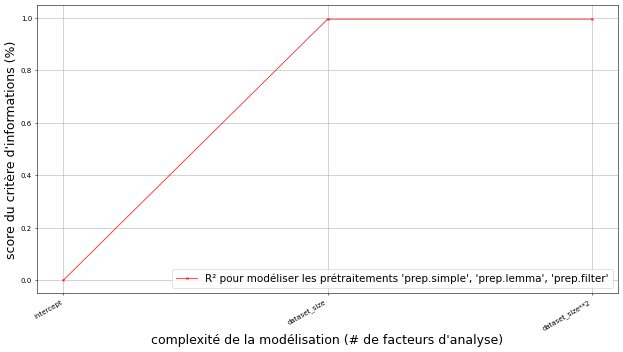

In [127]:
# Compute correlation of factors for preprocessing.
df_correlation_preprocessing: pd.DataFrame = compute_correlation_of_factors(
    df=df_preprocessing,
    factors_interactions=factors_interactions_for_preprocessing,
    algorithm_name=None,
)
# Print evolution of information score per model complexity.
information_score_evolution_for_preprocessing = compute_information_score_evolution(
    df=df_preprocessing,
    df_correlation=df_correlation_preprocessing,
    factors_interactions=factors_interactions_for_preprocessing,
    algorithm_name=None,
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-1prep.png",
    graph_plot_description="R² pour modéliser les prétraitements 'prep.simple', 'prep.lemma', 'prep.filter'",
)
df_correlation_preprocessing

In [147]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_prep = compare_glm_models(
    df=df_preprocessing,
    algorithm_name=None,
    formulas=[
        "time_total ~ 1",
        "time_total ~ 0 + X1POW1",
        "time_total ~ 1 + X1POW1",
    ],
)
df_scores_prep

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,0.000004,-1353.983674
1,time_total ~ 0 + X1POW1,0,1.000000,-432.427899
2,time_total ~ 1 + X1POW1,1,1.000000,-379.348858


> `preprocessing ~ 1 + dataset_size`

In [133]:
# Fit the model to the data and print results.
best_model_prep = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW1",  # X1POW1=dataset_size
    data=df_preprocessing,
)
best_results_prep = best_model_prep.fit()
print("==============================================================================")
print(">>> formula:", best_model_prep.formula)
print("==============================================================================")
print("   ", best_results_prep.summary())

>>> formula: time_total ~ 1 + X1POW1
                     Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                  375
Model:                            GLM   Df Residuals:                      373
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.44515
Method:                          IRLS   Log-Likelihood:                -379.35
Date:                Thu, 25 May 2023   Deviance:                       166.04
Time:                        15:03:24   Pearson chi2:                     166.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

In [134]:
# Print the modelization.
print(
    "preprocessing ~",
    "{0:.2E}".format(best_results_prep.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_prep.params["X1POW1"], factors_interactions_for_preprocessing["X1POW1"]),
)

preprocessing ~ 8.93E-01 + 6.31E-03*dataset_size


In [135]:
# Define the interpolation function.
def interpolation_prep(dataset_size) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_prep.params["Intercept"] - best_results_prep.bse["Intercept"])
    res += best_results_prep.params["Intercept"]
    res_high += (best_results_prep.params["Intercept"] + best_results_prep.bse["Intercept"])
    # dataset_size.
    res_low += (best_results_prep.params["X1POW1"] - best_results_prep.bse["X1POW1"]) * dataset_size
    res += best_results_prep.params["X1POW1"] * dataset_size
    res_high += (best_results_prep.params["X1POW1"] + best_results_prep.bse["X1POW1"]) * dataset_size
    # Return.
    return res_low, res, res_high

### 3.1.2. Print all preprocessing computation time model.

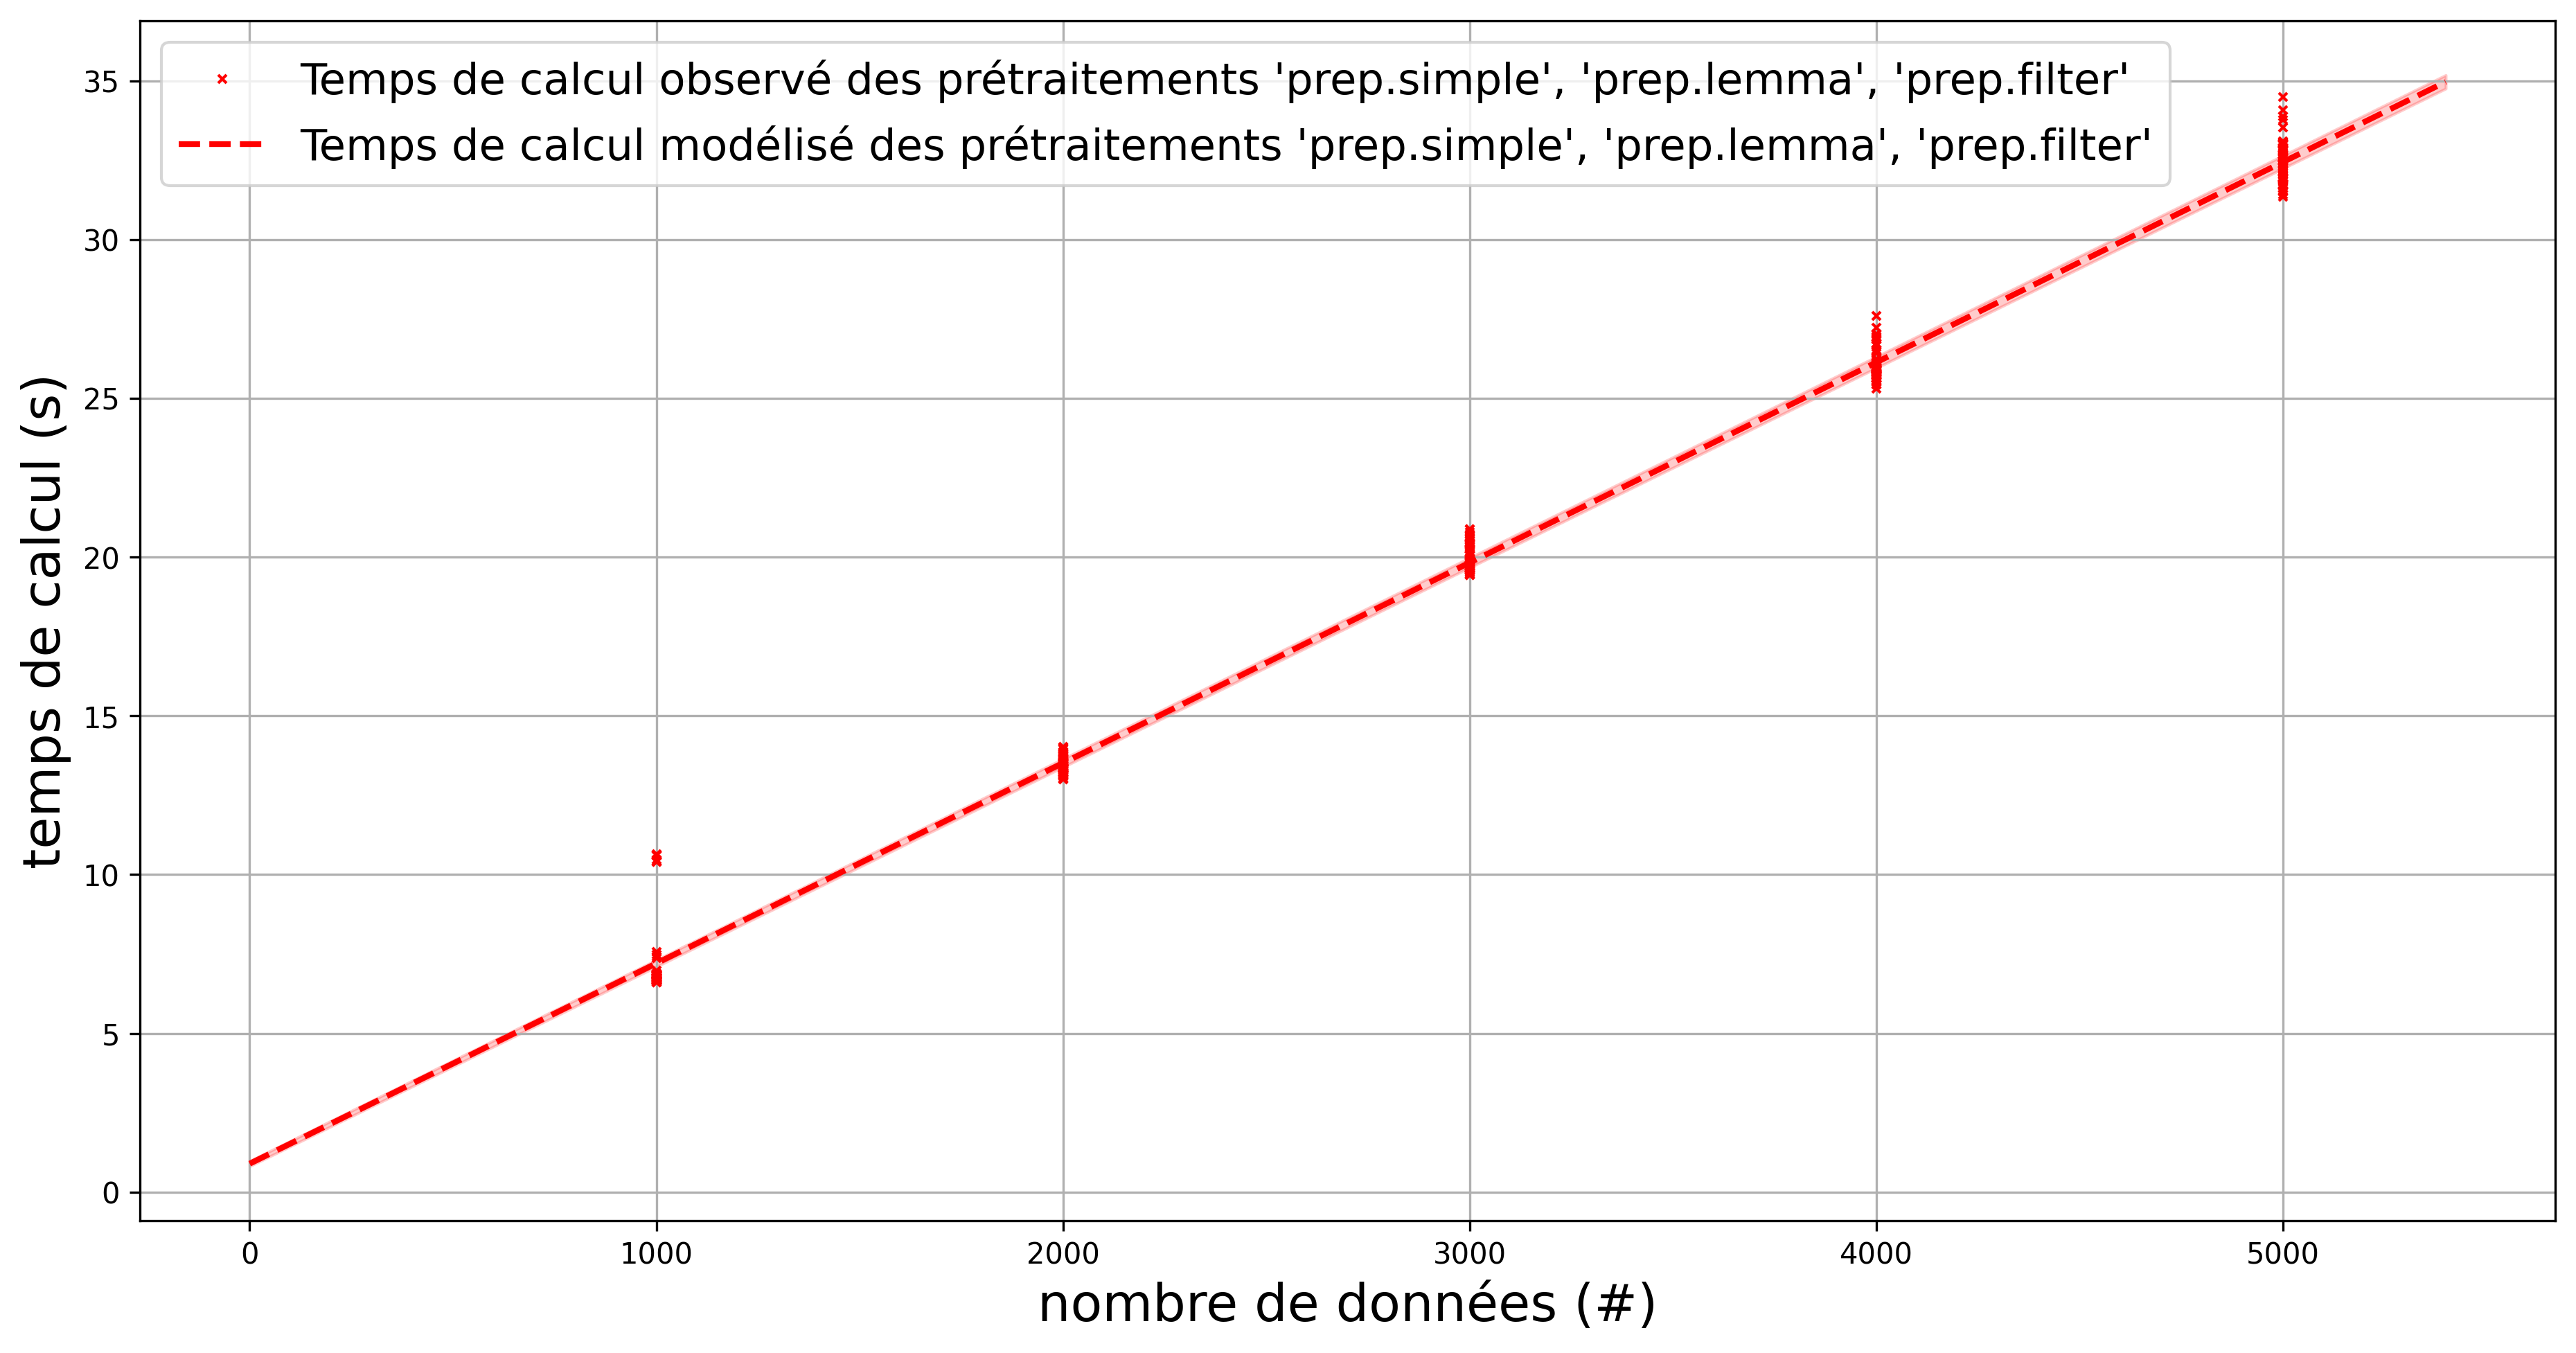

In [136]:
# Create a new figure.
fig_plot_preprocessing: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_preprocessing = fig_plot_preprocessing.gca()

# Plot computation time for preprocessing.
axis_plot_preprocessing.plot(
    df_preprocessing["dataset_size"],  # x
    df_preprocessing["time_total"],  # y
    label="Temps de calcul observé des prétraitements 'prep.simple', 'prep.lemma', 'prep.filter'",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_preprocessing.plot(
    range(0, 5500, 100),  # x
    [
        interpolation_prep(x)[1]
        for x in range(0, 5500, 100)
    ],  # y
    label="Temps de calcul modélisé des prétraitements 'prep.simple', 'prep.lemma', 'prep.filter'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
axis_plot_preprocessing.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        interpolation_prep(x)[0]
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        interpolation_prep(x)[2]
        for x in range(0, 5500, 100)
    ],  # y2
    color="red",
    alpha=0.2,
)

# Set axis name.
axis_plot_preprocessing.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_preprocessing.set_ylabel("temps de calcul (s)", fontsize=18,)

# Plot the legend.
axis_plot_preprocessing.legend(
    loc="upper left",
    fontsize=15,
)

# Plot the grid.
axis_plot_preprocessing.grid(True)
    
# Store the graph.
fig_plot_preprocessing.savefig(
    "../results/etude-temps-calcul-modelisation-1prep.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

----------

## 2.2. ANALYSIS FOR VECTORIZATION

> - algorithms: `tfidf`, `spacy`
> - factors: `dataset_size`

In [137]:
df_vectorization = pd.read_csv("../results/experiments_synthesis_for_vectorization.csv", sep=";", index_col=0)
df_vectorization["time_total"] = df_vectorization["time_total"].str.replace(",", ".").astype(float)
df_vectorization.head()

,dataset_name,dataset_size,dataset_random_seed,algorithm_name,algorithm_random_seed,time_start,time_stop,time_total
../experiments/vectorization/bank_cards_v2-size_1000-rand_1/spacy-rand_1/,bank_cards_v2,1000,1,spacy,1,1668606299,1668606306,6.537537
../experiments/vectorization/bank_cards_v2-size_1000-rand_1/spacy-rand_2/,bank_cards_v2,1000,1,spacy,2,1668606299,1668606305,5.808981
../experiments/vectorization/bank_cards_v2-size_1000-rand_1/spacy-rand_3/,bank_cards_v2,1000,1,spacy,3,1668606299,1668606305,5.677907
../experiments/vectorization/bank_cards_v2-size_1000-rand_1/spacy-rand_4/,bank_cards_v2,1000,1,spacy,4,1668606300,1668606306,6.582016
../experiments/vectorization/bank_cards_v2-size_1000-rand_1/spacy-rand_5/,bank_cards_v2,1000,1,spacy,5,1668606306,1668606312,6.184443


In [138]:
# Compute interaction of factors for preprocessing.
factors_interactions_for_vectorization, df_vectorization = compute_combinations_of_interactions_of_factors(
    df=df_vectorization,
    factors=["dataset_size"],
    range_of_powers=[0, 1, 2],
    max_power=3
)
factors_interactions_for_vectorization

{'X1POW1': 'dataset_size', 'X1POW2': 'dataset_size**2'}

### 2.2.0. Dertermine if vectorization computation time is `algorithm_name` dependant.

In [139]:
# Fit the model to the data and print results.
model_vect_ALGONAME = statsmodels.formula.api.glm(
    formula="time_total ~ C(algorithm_name)",
    data=df_vectorization,
)
results_vect_ALGONAME = model_vect_ALGONAME.fit()
print(results_vect_ALGONAME.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                  250
Model:                            GLM   Df Residuals:                      248
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          17.598
Method:                          IRLS   Log-Likelihood:                -712.21
Date:                Thu, 25 May 2023   Deviance:                       4364.4
Time:                        15:04:12   Pearson chi2:                 4.36e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9366
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 2.2.1 Modelize `tfidf` vectorization `algorithm_name`.

,r,r^2,full_name
X1POW1,0.976681,0.953905,dataset_size
X1POW2,0.963695,0.928708,dataset_size**2


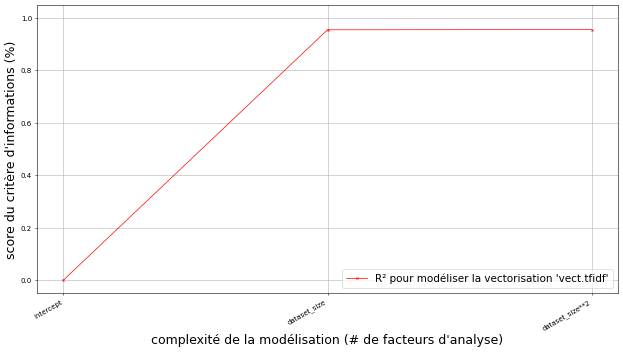

In [148]:
# Compute correlation of factors for vectorization.
df_correlation_vectorization_tfidf: pd.DataFrame = compute_correlation_of_factors(
    df=df_vectorization,
    factors_interactions=factors_interactions_for_vectorization,
    algorithm_name="tfidf",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_vectorization_tfidf = compute_information_score_evolution(
    df=df_vectorization,
    df_correlation=df_correlation_vectorization_tfidf,
    factors_interactions=factors_interactions_for_vectorization,
    algorithm_name="tfidf",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-2vect-tfidf.png",
    graph_plot_description="R² pour modéliser la vectorisation 'vect.tfidf'",
)
df_correlation_vectorization_tfidf

In [149]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_vectorization_tfidf = compare_glm_models(
    df=df_vectorization,
    algorithm_name="tfidf",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 0 + X1POW1",
        "time_total ~ 1 + X1POW1",
    ],
)
df_scores_vectorization_tfidf

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,0.000032,70.042140
1,time_total ~ 0 + X1POW1,0,1.000000,259.886181
2,time_total ~ 1 + X1POW1,1,1.000000,262.358081


> `vectorization.tfidf ~ 1 + dataset_size`

In [150]:
# Fit the model to the data and print results.
best_model_vect_tfidf = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW1",  # X1POW1 = dataset_size
    data=df_vectorization[df_vectorization["algorithm_name"]=="tfidf"],
)
best_results_vect_tfidf = best_model_vect_tfidf.fit()
print("==============================================================================")
print(">>> formula:", best_model_vect_tfidf.formula)
print("==============================================================================")
print(best_results_vect_tfidf.summary())

>>> formula: time_total ~ 1 + X1POW1
                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                  125
Model:                            GLM   Df Residuals:                      123
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      0.00089429
Method:                          IRLS   Log-Likelihood:                 262.36
Date:                Thu, 25 May 2023   Deviance:                      0.11000
Time:                        15:06:55   Pearson chi2:                    0.110
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -

In [151]:
# Print the modelization.
print(
    "vectorisation.tfidf ~",
    "{0:.2E}".format(best_results_vect_tfidf.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_vect_tfidf.params["X1POW1"], factors_interactions_for_vectorization["X1POW1"])
)

vectorisation.tfidf ~ -1.40E-02 + 9.54E-05*dataset_size


In [154]:
# Define the interpolation function.
def interpolation_vect_tfidf(dataset_size) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_vect_tfidf.params["Intercept"] - best_results_vect_tfidf.bse["Intercept"])
    res += best_results_vect_tfidf.params["Intercept"]
    res_high += (best_results_vect_tfidf.params["Intercept"] + best_results_vect_tfidf.bse["Intercept"])
    # dataset_size.
    res_low += (best_results_vect_tfidf.params["X1POW1"] - best_results_vect_tfidf.bse["X1POW1"]) * dataset_size
    res += best_results_vect_tfidf.params["X1POW1"] * dataset_size
    res_high += (best_results_vect_tfidf.params["X1POW1"] + best_results_vect_tfidf.bse["X1POW1"]) * dataset_size
    # Return.
    return res_low, res, res_high

### 2.2.2. Modelize `frcorenewsmd` vectorization `algorithm_name`.

,r,r^2,full_name
X1POW1,0.983196,0.966674,dataset_size
X1POW2,0.964329,0.929930,dataset_size**2


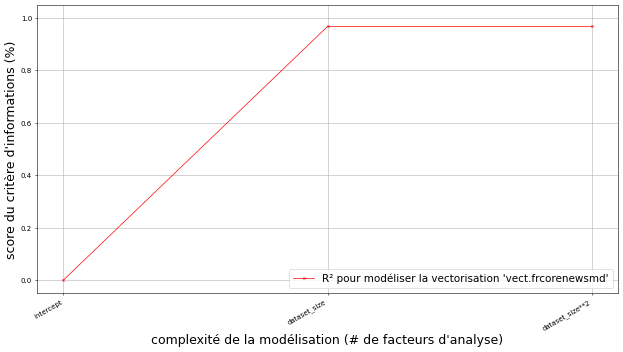

In [157]:
# Compute correlation of factors for vectorization.
df_correlation_vectorization_frcorenewsmd: pd.DataFrame = compute_correlation_of_factors(
    df=df_vectorization,
    factors_interactions=factors_interactions_for_vectorization,
    algorithm_name="spacy",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_vectorization_frcorenewsmd = compute_information_score_evolution(
    df=df_vectorization,
    df_correlation=df_correlation_vectorization_frcorenewsmd,
    factors_interactions=factors_interactions_for_vectorization,
    algorithm_name="spacy",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-2vect-frcorenewsmd.png",
    graph_plot_description="R² pour modéliser la vectorisation 'vect.frcorenewsmd'",
)
df_correlation_vectorization_frcorenewsmd

In [158]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_vectorization_frcorenewsmd = compare_glm_models(
    df=df_vectorization,
    algorithm_name="spacy",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 0 + X1POW1",
        "time_total ~ 1 + X1POW1",
    ],
)
df_scores_vectorization_frcorenewsmd

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,0.000032,-399.390126
1,time_total ~ 0 + X1POW1,0,1.000000,-214.442614
2,time_total ~ 1 + X1POW1,1,1.000000,-186.801007


> `vectorization.spacy ~ 1 + dataset_size`

In [159]:
# Fit the model to the data and print results.
best_model_vect_frcorenewsmd = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW1",  # X1POW1 = dataset_size
    data=df_vectorization[df_vectorization["algorithm_name"]=="spacy"],
)
best_results_vect_frcorenewsmd = best_model_vect_frcorenewsmd.fit()
print("==============================================================================")
print(">>> formula:", best_model_vect_frcorenewsmd.formula)
print("==============================================================================")
print(best_results_vect_frcorenewsmd.summary())

>>> formula: time_total ~ 1 + X1POW1
                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                  125
Model:                            GLM   Df Residuals:                      123
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.1818
Method:                          IRLS   Log-Likelihood:                -186.80
Date:                Thu, 25 May 2023   Deviance:                       145.37
Time:                        15:08:47   Pearson chi2:                     145.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

In [160]:
# Print the modelization.
print(
    "vectorization.frcorenewsmd ~",
    "{0:.2E}".format(best_results_vect_frcorenewsmd.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_vect_frcorenewsmd.params["X1POW1"], factors_interactions_for_vectorization["X1POW1"])
)

vectorization.frcorenewsmd ~ 1.89E+00 + 4.11E-03*dataset_size


In [161]:
# Define the interpolation function.
def interpolation_vect_frcorenewsmd(dataset_size) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_vect_frcorenewsmd.params["Intercept"] - best_results_vect_frcorenewsmd.bse["Intercept"])
    res += best_results_vect_frcorenewsmd.params["Intercept"]
    res_high += (best_results_vect_frcorenewsmd.params["Intercept"] + best_results_vect_frcorenewsmd.bse["Intercept"])
    # dataset_size.
    res_low += (best_results_vect_frcorenewsmd.params["X1POW1"] - best_results_vect_frcorenewsmd.bse["X1POW1"]) * dataset_size
    res += best_results_vect_frcorenewsmd.params["X1POW1"] * dataset_size
    res_high += (best_results_vect_frcorenewsmd.params["X1POW1"] + best_results_vect_frcorenewsmd.bse["X1POW1"]) * dataset_size
    # Return.
    return res_low, res, res_high

### 2.2.3. Print all vectorization computation time model.

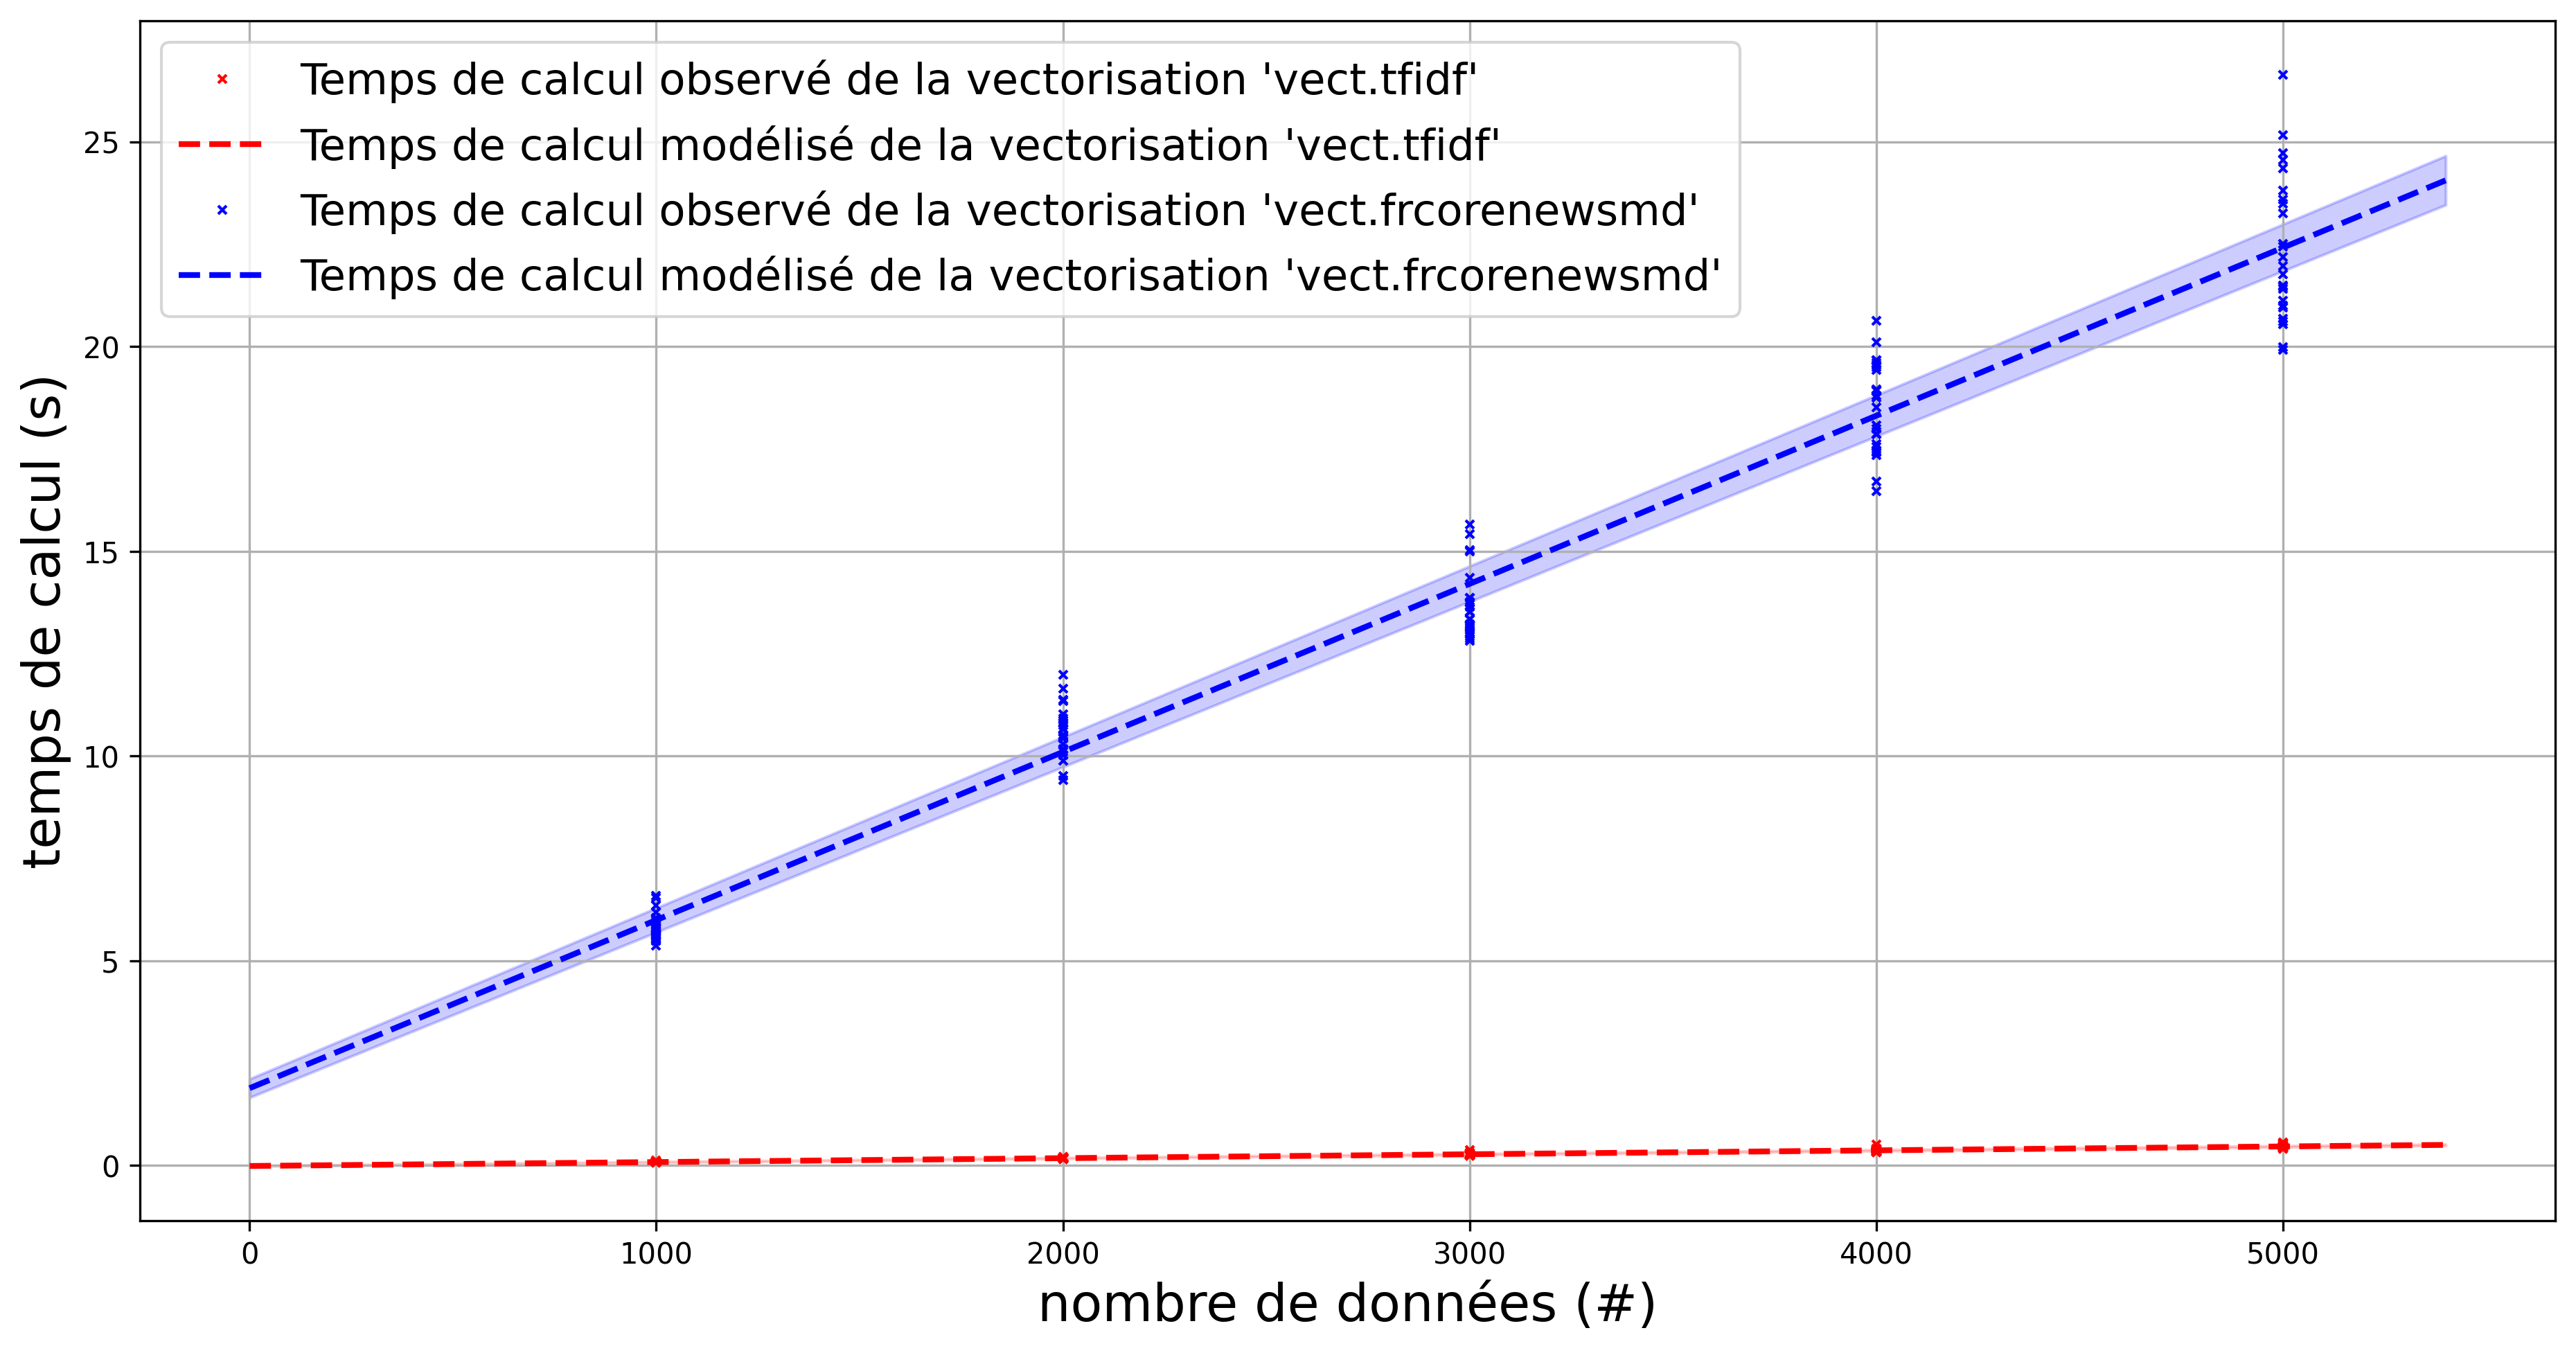

In [162]:
# Create a new figure.
fig_plot_vectorization: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_vectorization = fig_plot_vectorization.gca()

# Plot computation time for tfidf.
axis_plot_vectorization.plot(
    df_vectorization[df_vectorization["algorithm_name"]=="tfidf"]["dataset_size"],  # x
    df_vectorization[df_vectorization["algorithm_name"]=="tfidf"]["time_total"],  # y
    label="Temps de calcul observé de la vectorisation 'vect.tfidf'",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_vectorization.plot(
    range(0, 5500, 100),  # x
    [
        interpolation_vect_tfidf(x)[1]
        for x in range(0, 5500, 100)
    ],  # y
    label="Temps de calcul modélisé de la vectorisation 'vect.tfidf'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
axis_plot_vectorization.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        interpolation_vect_tfidf(x)[0]
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        interpolation_vect_tfidf(x)[2]
        for x in range(0, 5500, 100)
    ],  # y2
    color="red",
    alpha=0.2,
)

# Plot computation time for frcorenewsmd.
axis_plot_vectorization.plot(
    df_vectorization[df_vectorization["algorithm_name"]=="spacy"]["dataset_size"],  # x
    df_vectorization[df_vectorization["algorithm_name"]=="spacy"]["time_total"],  # y
    label="Temps de calcul observé de la vectorisation 'vect.frcorenewsmd'",
    marker="x",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=0,
    linestyle="",
)
axis_plot_vectorization.plot(
    range(0, 5500, 100),  # x
    [
        interpolation_vect_frcorenewsmd(x)[1]
        for x in range(0, 5500, 100)
    ],  # y
    label="Temps de calcul modélisé de la vectorisation 'vect.frcorenewsmd'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
axis_plot_vectorization.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        interpolation_vect_frcorenewsmd(x)[0]
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        interpolation_vect_frcorenewsmd(x)[2]
        for x in range(0, 5500, 100)
    ],  # y2
    color="blue",
    alpha=0.2,
)

# Set axis name.
axis_plot_vectorization.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_vectorization.set_ylabel("temps de calcul (s)", fontsize=18,)

# Plot the legend.
axis_plot_vectorization.legend(
    loc="upper left",
    fontsize=15,
)

# Plot the grid.
axis_plot_vectorization.grid(True)

# Store the graph.
fig_plot_vectorization.savefig(
    "../results/etude-temps-calcul-modelisation-2vect.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

----------

## 2.3. ANALYSIS FOR CLUSTERING

> - algorithms: `kmeans_COP`, `hier_single`, `hier_complete`, `hier_average`, `hier_ward`, `spectral_SPEC`
> - factors: `dataset_size`, `previous_nb_constraints`, `algorithm_nb_clusters`

In [163]:
df_clustering = pd.read_csv("../results/experiments_synthesis_for_clustering.csv", sep=";", index_col=0)
df_clustering["time_total"] = df_clustering["time_total"].str.replace(",", ".").astype(float)
df_clustering.head()

,dataset_name,dataset_size,dataset_random_seed,previous_nb_constraints,algorithm_name,algorithm_random_seed,algorithm_nb_clusters,time_start,time_stop,time_total
../experiments/clustering/bank_cards_v2-size_1000-rand_1/hier_average-clusters_10-rand_1-prev_const0/,bank_cards_v2,1000,1,0,hier_average,1,10,1669766342,1669767048,706.108339
../experiments/clustering/bank_cards_v2-size_1000-rand_1/hier_average-clusters_10-rand_1-prev_const1000/,bank_cards_v2,1000,1,1000,hier_average,1,10,1669767302,1669767777,474.837071
../experiments/clustering/bank_cards_v2-size_1000-rand_1/hier_average-clusters_10-rand_1-prev_const1500/,bank_cards_v2,1000,1,1500,hier_average,1,10,1669767733,1669768149,416.317765
../experiments/clustering/bank_cards_v2-size_1000-rand_1/hier_average-clusters_10-rand_1-prev_const2000/,bank_cards_v2,1000,1,2000,hier_average,1,10,1669768104,1669768487,382.944872
../experiments/clustering/bank_cards_v2-size_1000-rand_1/hier_average-clusters_10-rand_1-prev_const2500/,bank_cards_v2,1000,1,2500,hier_average,1,10,1669768454,1669768777,322.408471


In [164]:
# Compute interaction of factors for clustering.
factors_interactions_for_clustering, df_clustering = compute_combinations_of_interactions_of_factors(
    df=df_clustering,
    factors=["dataset_size", "previous_nb_constraints", "algorithm_nb_clusters"],
    range_of_powers=[0, 1, 2],
    max_power=3,
)
factors_interactions_for_clustering

{'X1POW1': 'dataset_size',
 'X2POW1': 'previous_nb_constraints',
 'X3POW1': 'algorithm_nb_clusters',
 'X1POW2': 'dataset_size**2',
 'X2POW2': 'previous_nb_constraints**2',
 'X3POW2': 'algorithm_nb_clusters**2',
 'X1POW1_X2POW1': '(dataset_size) * (previous_nb_constraints)',
 'X1POW1_X3POW1': '(dataset_size) * (algorithm_nb_clusters)',
 'X2POW1_X3POW1': '(previous_nb_constraints) * (algorithm_nb_clusters)',
 'X1POW2_X2POW1': '(dataset_size**2) * (previous_nb_constraints)',
 'X1POW2_X3POW1': '(dataset_size**2) * (algorithm_nb_clusters)',
 'X1POW1_X2POW2': '(dataset_size) * (previous_nb_constraints**2)',
 'X1POW1_X3POW2': '(dataset_size) * (algorithm_nb_clusters**2)',
 'X2POW2_X3POW1': '(previous_nb_constraints**2) * (algorithm_nb_clusters)',
 'X2POW1_X3POW2': '(previous_nb_constraints) * (algorithm_nb_clusters**2)',
 'X1POW1_X2POW1_X3POW1': '(dataset_size) * (previous_nb_constraints) * (algorithm_nb_clusters)'}

### 2.3.0. Dertermine if clustering computation time is `algorithm_name` dependant.

In [165]:
# Fit the model to the data and print results.
model_clust_ALGONAME = statsmodels.formula.api.glm(
    formula="time_total ~ C(algorithm_name)",
    data=df_clustering,
)
results_clust_ALGONAME = model_clust_ALGONAME.fit()
print(results_clust_ALGONAME.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                54340
Model:                            GLM   Df Residuals:                    54334
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                      3.3946e+06
Method:                          IRLS   Log-Likelihood:            -4.8568e+05
Date:                Thu, 25 May 2023   Deviance:                   1.8444e+11
Time:                        15:09:41   Pearson chi2:                 1.84e+11
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2094
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

### 2.3.1. Modelize `kmeans_COP` clustering `algorithm_name`.

,r,r^2,full_name
X1POW1,0.837250,0.700987,dataset_size
X1POW2,0.822181,0.675982,dataset_size**2
X1POW2_X3POW1,0.544722,0.296722,(dataset_size**2) * (algorithm_nb_clusters)
X1POW1_X2POW1,0.479962,0.230364,(dataset_size) * (previous_nb_constraints)
X1POW1_X3POW1,0.434943,0.189175,(dataset_size) * (algorithm_nb_clusters)
X1POW1_X2POW1_X3POW1,0.302220,0.091337,(dataset_size) * (previous_nb_constraints) * (...
X1POW1_X3POW2,0.275571,0.075939,(dataset_size) * (algorithm_nb_clusters**2)
X3POW1,0.095701,0.009159,algorithm_nb_clusters
X3POW2,0.090403,0.008173,algorithm_nb_clusters**2
X1POW2_X2POW1,0.073094,0.005343,(dataset_size**2) * (previous_nb_constraints)


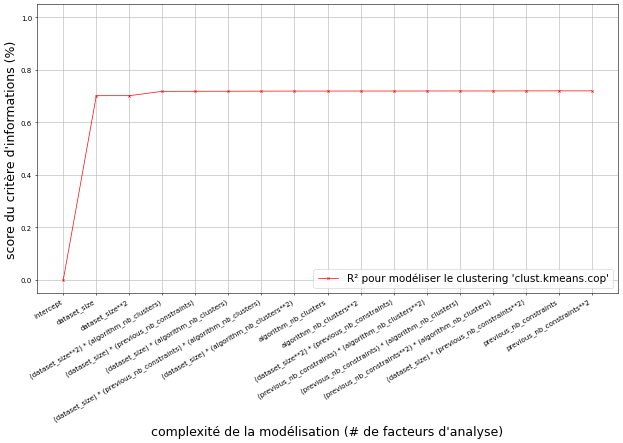

In [167]:
# Compute correlation of factors for clustering.
df_correlation_clustering_kmeans_COP: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="kmeans_COP",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_clustering_kmeans_COP = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_kmeans_COP,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="kmeans_COP",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-3clust-kmeans-cop.png",
    graph_plot_description="R² pour modéliser le clustering 'clust.kmeans.cop'",
)
df_correlation_clustering_kmeans_COP

In [210]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_clustering_kmeans_COP = compare_glm_models(
    df=df_clustering,
    algorithm_name="kmeans_COP",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 1 + X1POW1",
        "time_total ~ 1 + X1POW2_X3POW1",
    ],
)
df_scores_clustering_kmeans_COP

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,2.644755e-09,-100276.253796
1,time_total ~ 1 + X1POW1,1,9.040563e-01,-91976.288066
2,time_total ~ 1 + X1POW2_X3POW1,1,3.441683e-01,-97856.235137


> `clustering.kmeans_COP ~ 1 + dataset_size`

In [173]:
# Fit the model to the data and print results.
best_model_clust_kmeans_COP = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW1",  # dataset_size, (dataset_size**2)*(algorithm_nb_clusters)
    data=df_clustering[df_clustering["algorithm_name"]=="kmeans_COP"],
)
best_results_clust_kmeans_COP = best_model_clust_kmeans_COP.fit()
print("==============================================================================")
print(">>> formula:", best_model_clust_kmeans_COP.formula)
print("==============================================================================")
print(best_results_clust_kmeans_COP.summary())

>>> formula: time_total ~ 1 + X1POW1
                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                13750
Model:                            GLM   Df Residuals:                    13748
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          37822.
Method:                          IRLS   Log-Likelihood:                -91976.
Date:                Thu, 25 May 2023   Deviance:                   5.1997e+08
Time:                        15:20:02   Pearson chi2:                 5.20e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9041
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -23

In [174]:
# Print the modelization.
print(
    "clustering.kmeans.cop ~",
    "{0:.2E}".format(best_results_clust_kmeans_COP.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_clust_kmeans_COP.params["X1POW1"], factors_interactions_for_clustering["X1POW1"])
    # "+ {0:.2E}(+/-{1:.2E})*{2}".format(best_results_clust_kmeans_COP.params["X1POW2_X3POW1"], best_results_clust_kmeans_COP.bse["X1POW2_X3POW1"], factors_interactions_for_clustering["X1POW2_X3POW1"])
)

clustering.kmeans.cop ~ -2.40E+02 + 2.11E-01*dataset_size


In [175]:
# Define the interpolation function.
def interpolation_clust_kmeans_COP(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_clust_kmeans_COP.params["Intercept"] - best_results_clust_kmeans_COP.bse["Intercept"])
    res += best_results_clust_kmeans_COP.params["Intercept"]
    res_high += (best_results_clust_kmeans_COP.params["Intercept"] + best_results_clust_kmeans_COP.bse["Intercept"])
    # dataset_size.
    res_low += (best_results_clust_kmeans_COP.params["X1POW1"] - best_results_clust_kmeans_COP.bse["X1POW1"]) * dataset_size
    res += best_results_clust_kmeans_COP.params["X1POW1"] * dataset_size
    res_high += (best_results_clust_kmeans_COP.params["X1POW1"] + best_results_clust_kmeans_COP.bse["X1POW1"]) * dataset_size
    # (dataset_size**2)*(algorithm_nb_clusters)
    res_low += 0  # (best_results_clust_kmeans_COP.params["X1POW2_X3POW1"] - best_results_clust_kmeans_COP.bse["X1POW2_X3POW1"]) * (dataset_size**2)*(algorithm_nb_clusters)
    res += 0  # best_results_clust_kmeans_COP.params["X1POW2_X3POW1"] * (dataset_size**2)*(algorithm_nb_clusters)
    res_high += 0  # (best_results_clust_kmeans_COP.params["X1POW2_X3POW1"] + best_results_clust_kmeans_COP.bse["X1POW2_X3POW1"]) * (dataset_size**2)*(algorithm_nb_clusters)
    # Return.
    return res_low, res, res_high

### 2.3.2. Modelize `hier_single` clustering `algorithm_name`.

,r,r^2,full_name
X1POW2,0.940109,8.838048e-01,dataset_size**2
X1POW1,0.870935,7.585271e-01,dataset_size
X1POW2_X3POW1,0.729322,5.319103e-01,(dataset_size**2) * (algorithm_nb_clusters)
X1POW1_X3POW1,0.526281,2.769712e-01,(dataset_size) * (algorithm_nb_clusters)
X1POW1_X3POW2,0.371005,1.376449e-01,(dataset_size) * (algorithm_nb_clusters**2)
X1POW1_X2POW1,0.288860,8.344007e-02,(dataset_size) * (previous_nb_constraints)
X1POW1_X2POW1_X3POW1,0.222482,4.949830e-02,(dataset_size) * (previous_nb_constraints) * (...
X2POW1,0.156882,2.461205e-02,previous_nb_constraints
X2POW2,0.143976,2.072897e-02,previous_nb_constraints**2
X1POW2_X2POW1,0.142889,2.041725e-02,(dataset_size**2) * (previous_nb_constraints)


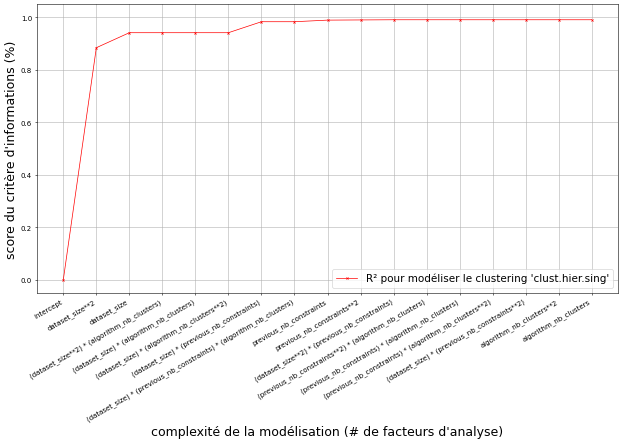

In [176]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_single: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_single",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_clustering_hier_single = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_single,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_single",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-3clust-hier-sing.png",
    graph_plot_description="R² pour modéliser le clustering 'clust.hier.sing'",
)
df_correlation_clustering_hier_single

In [209]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_clustering_hier_sing = compare_glm_models(
    df=df_clustering,
    algorithm_name="hier_single",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 1 + X1POW2",
        "time_total ~ 1 + X1POW2_X3POW1",
    ],
)
df_scores_clustering_hier_sing

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,1.110626e-08,-61018.632454
1,time_total ~ 1 + X1POW2,1,9.995015e-01,-53797.050482
2,time_total ~ 1 + X1POW2_X3POW1,1,6.789004e-01,-58471.867506


> `clustering.hier_sing ~ 1 + dataset_size**2`

In [181]:
# Fit the model to the data and print results.
best_model_clust_hier_single = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW2",  # dataset_size**2
    data=df_clustering[df_clustering["algorithm_name"]=="hier_single"],
)
best_results_clust_hier_single = best_model_clust_hier_single.fit()
print(best_results_clust_hier_single.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                 6710
Model:                            GLM   Df Residuals:                     6708
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      5.3891e+05
Method:                          IRLS   Log-Likelihood:                -53797.
Date:                Thu, 25 May 2023   Deviance:                   3.6150e+09
Time:                        15:26:04   Pearson chi2:                 3.62e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9995
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -886.5641     13.940    -63.598      0.0

In [183]:
# Print the modelization.
print(
    "clustering.hier.sing ~",
    "{0:.2E}".format(best_results_clust_hier_single.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_clust_hier_single.params["X1POW2"], factors_interactions_for_clustering["X1POW2"]),
    #"+ {0:.2E}*{1}".format(best_results_clust_hier_single.params["X1POW1_X2POW1"], factors_interactions_for_clustering["X1POW1_X2POW1"]),
)

clustering.hier.sing ~ -8.87E+02 + 6.37E-04*dataset_size**2


In [48]:
# Define the interpolation function.
def interpolation_clust_hier_single(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_clust_hier_single.params["Intercept"] - best_results_clust_hier_single.bse["Intercept"])
    res += best_results_clust_hier_single.params["Intercept"]
    res_high += (best_results_clust_hier_single.params["Intercept"] + best_results_clust_hier_single.bse["Intercept"])
    # dataset_size**2.
    res_low += (best_results_clust_hier_single.params["X1POW2"] - best_results_clust_hier_single.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_clust_hier_single.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_clust_hier_single.params["X1POW2"] + best_results_clust_hier_single.bse["X1POW2"]) * np.power(dataset_size,2)
    # dataset_size*previous_nb_constraints.
    res_low += 0.0  # (best_results_clust_hier_single.params["X1POW2"] - best_results_clust_hier_single.bse["X1POW1_X2POW1"]) * dataset_size*previous_nb_constraints
    res += 0.0  # best_results_clust_hier_single.params["X1POW1_X2POW1"] * dataset_size*previous_nb_constraints
    res_high += 0.0  # (best_results_clust_hier_single.params["X1POW1_X2POW1"] + best_results_clust_hier_single.bse["X1POW2"]) * dataset_size*previous_nb_constraints
    # Return.
    return res_low, res, res_high

### 2.3.3. Modelize `hier_complete` clustering `algorithm_name`.

,r,r^2,full_name
X1POW2,0.937754,0.879383,dataset_size**2
X1POW1,0.865066,0.748339,dataset_size
X1POW2_X3POW1,0.736430,0.542329,(dataset_size**2) * (algorithm_nb_clusters)
X1POW1_X3POW1,0.530327,0.281247,(dataset_size) * (algorithm_nb_clusters)
X1POW1_X3POW2,0.377322,0.142372,(dataset_size) * (algorithm_nb_clusters**2)
X1POW1_X2POW1,0.320549,0.102752,(dataset_size) * (previous_nb_constraints)
X1POW1_X2POW1_X3POW1,0.254569,0.064805,(dataset_size) * (previous_nb_constraints) * (...
X1POW2_X2POW1,0.142268,0.020240,(dataset_size**2) * (previous_nb_constraints)
X2POW1,0.128518,0.016517,previous_nb_constraints
X2POW2,0.121209,0.014692,previous_nb_constraints**2


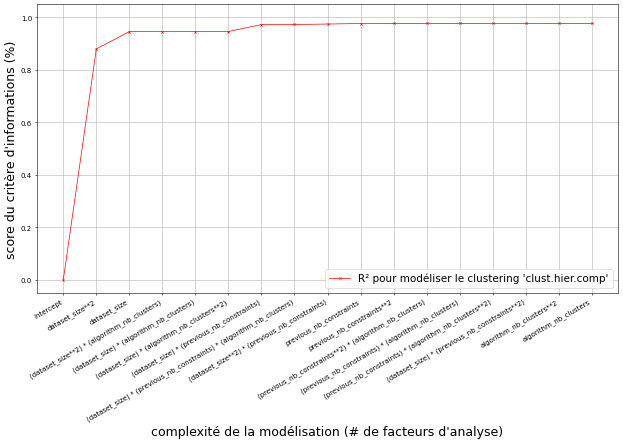

In [184]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_complete: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_complete",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_clustering_hier_complete = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_complete,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_complete",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-3clust-hier-comp.png",
    graph_plot_description="R² pour modéliser le clustering 'clust.hier.comp'",
)
df_correlation_clustering_hier_complete

In [208]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_clustering_hier_comp = compare_glm_models(
    df=df_clustering,
    algorithm_name="hier_complete",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 1 + X1POW2",
        "time_total ~ 1 + X1POW2_X3POW1",
    ],
)
df_scores_clustering_hier_comp

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,1.110627e-08,-61094.084470
1,time_total ~ 1 + X1POW2,1,9.993167e-01,-53997.817475
2,time_total ~ 1 + X1POW2_X3POW1,1,6.941389e-01,-58471.798332


> `clustering.hier_complete ~ 1 + dataset_size**2`

In [191]:
# Fit the model to the data and print results.
best_model_clust_hier_complete = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW2",  # dataset_size**2
    data=df_clustering[df_clustering["algorithm_name"]=="hier_complete"],
)
best_results_clust_hier_complete = best_model_clust_hier_complete.fit()
print(best_results_clust_hier_complete.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                 6710
Model:                            GLM   Df Residuals:                     6708
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      5.7215e+05
Method:                          IRLS   Log-Likelihood:                -53998.
Date:                Thu, 25 May 2023   Deviance:                   3.8380e+09
Time:                        17:55:26   Pearson chi2:                 3.84e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9993
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -924.8582     14.363    -64.390      0.0

In [192]:
# Print the modelization.
print(
    "clustering.hier.comp ~",
    "{0:.2E}".format(best_results_clust_hier_complete.params["Intercept"]),
    "+ {0:.2E}{1}".format(best_results_clust_hier_complete.params["X1POW2"], factors_interactions_for_clustering["X1POW2"])
)

clustering.hier.comp ~ -9.25E+02 + 6.42E-04dataset_size**2


In [193]:
# Define the interpolation function.
def interpolation_clust_hier_complete(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept
    res_low += (best_results_clust_hier_complete.params["Intercept"] - best_results_clust_hier_complete.bse["Intercept"])
    res += best_results_clust_hier_complete.params["Intercept"]
    res_high += (best_results_clust_hier_complete.params["Intercept"] + best_results_clust_hier_complete.bse["Intercept"])
    # X1POW2: dataset_size**2
    res_low += (best_results_clust_hier_complete.params["X1POW2"] - best_results_clust_hier_complete.bse["X1POW2"]) * np.power(dataset_size,2)
    res += (best_results_clust_hier_complete.params["X1POW2"]) * np.power(dataset_size,2)
    res_high += (best_results_clust_hier_complete.params["X1POW2"] + best_results_clust_hier_complete.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.3.4. Modelize `hier_average` clustering `algorithm_name`.

,r,r^2,full_name
X1POW2,0.915067,0.837347,dataset_size**2
X1POW1,0.858558,0.737123,dataset_size
X1POW2_X3POW1,0.712993,0.508359,(dataset_size**2) * (algorithm_nb_clusters)
X1POW1_X3POW1,0.521511,0.271973,(dataset_size) * (algorithm_nb_clusters)
X1POW1_X3POW2,0.367443,0.135014,(dataset_size) * (algorithm_nb_clusters**2)
X1POW1_X2POW1,0.270345,0.073087,(dataset_size) * (previous_nb_constraints)
X1POW1_X2POW1_X3POW1,0.208119,0.043314,(dataset_size) * (previous_nb_constraints) * (...
X2POW1,0.173152,0.029982,previous_nb_constraints
X2POW2,0.159304,0.025378,previous_nb_constraints**2
X1POW2_X2POW1,0.148169,0.021954,(dataset_size**2) * (previous_nb_constraints)


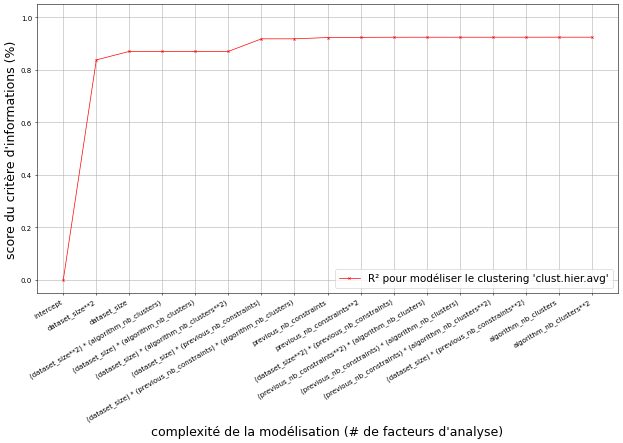

In [194]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_average: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_average",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_clustering_hier_average = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_average,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_average",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-3clust-hier-avg.png",
    graph_plot_description="R² pour modéliser le clustering 'clust.hier.avg'",
)
df_correlation_clustering_hier_average

In [211]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_clustering_hier_avg = compare_glm_models(
    df=df_clustering,
    algorithm_name="hier_average",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 1 + X1POW2",
        "time_total ~ 1 + X1POW2_X3POW1",
    ],
)
df_scores_clustering_hier_avg

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,1.110627e-08,-64366.038278
1,time_total ~ 1 + X1POW2,1,9.941804e-01,-58272.900285
2,time_total ~ 1 + X1POW2_X3POW1,1,6.443107e-01,-61983.964106


> `clustering.hier_average ~ 1 + dataset_size**2`

In [196]:
# Fit the model to the data and print results.
best_model_clust_hier_average = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW2",  # dataset_size**2
    data=df_clustering[df_clustering["algorithm_name"]=="hier_average"],
)
best_results_clust_hier_average = best_model_clust_hier_average.fit()
print(best_results_clust_hier_average.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                 6710
Model:                            GLM   Df Residuals:                     6708
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      2.0460e+06
Method:                          IRLS   Log-Likelihood:                -58273.
Date:                Thu, 25 May 2023   Deviance:                   1.3725e+10
Time:                        17:57:37   Pearson chi2:                 1.37e+10
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9942
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1096.1810     27.162    -40.357      0.0

In [198]:
# Print the modelization.
print(
    "clustering.hier.avg ~",
    "{0:.2E}".format(best_results_clust_hier_average.params["Intercept"]),
    "+ {0:.2E}{1}".format(best_results_clust_hier_average.params["X1POW2"], factors_interactions_for_clustering["X1POW2"])
)

clustering.hier.avg ~ -1.10E+03 + 1.02E-03dataset_size**2


In [199]:
# Define the interpolation function.
def interpolation_clust_hier_average(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept
    res_low += (best_results_clust_hier_average.params["Intercept"] - best_results_clust_hier_average.bse["Intercept"])
    res += best_results_clust_hier_average.params["Intercept"]
    res_high += (best_results_clust_hier_average.params["Intercept"] + best_results_clust_hier_average.bse["Intercept"])
    # X1POW2: dataset_size**2
    res_low += (best_results_clust_hier_average.params["X1POW2"] - best_results_clust_hier_average.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_clust_hier_average.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_clust_hier_average.params["X1POW2"] + best_results_clust_hier_average.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.3.5. Modelize `hier_ward` clustering `algorithm_name`.

,r,r^2,full_name
X1POW2,0.945494,8.939597e-01,dataset_size**2
X1POW1,0.875432,7.663804e-01,dataset_size
X1POW2_X3POW1,0.734109,5.389157e-01,(dataset_size**2) * (algorithm_nb_clusters)
X1POW1_X3POW1,0.529633,2.805108e-01,(dataset_size) * (algorithm_nb_clusters)
X1POW1_X3POW2,0.373457,1.394702e-01,(dataset_size) * (algorithm_nb_clusters**2)
X1POW1_X2POW1,0.305593,9.338691e-02,(dataset_size) * (previous_nb_constraints)
X1POW1_X2POW1_X3POW1,0.236398,5.588415e-02,(dataset_size) * (previous_nb_constraints) * (...
X1POW2_X2POW1,0.152245,2.317849e-02,(dataset_size**2) * (previous_nb_constraints)
X2POW1,0.144570,2.090035e-02,previous_nb_constraints
X2POW2,0.136118,1.852806e-02,previous_nb_constraints**2


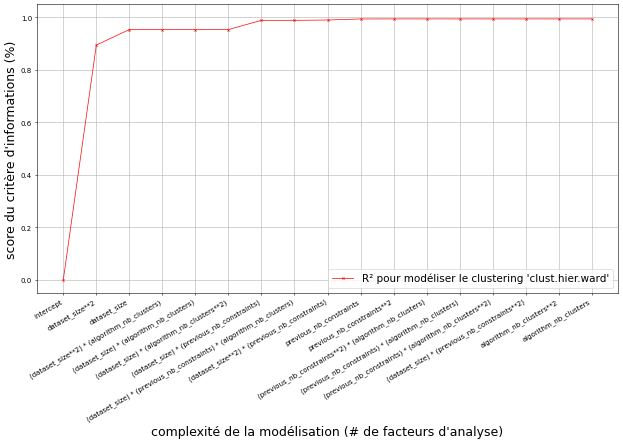

In [200]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_ward: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_ward",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_clustering_hier_ward = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_ward,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_ward",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-3clust-hier-ward.png",
    graph_plot_description="R² pour modéliser le clustering 'clust.hier.ward'",
)
df_correlation_clustering_hier_ward

In [212]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_clustering_hier_ward = compare_glm_models(
    df=df_clustering,
    algorithm_name="hier_ward",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 1 + X1POW2",
        "time_total ~ 1 + X1POW2_X3POW1",
    ],
)
df_scores_clustering_hier_ward

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,1.110627e-08,-61438.384875
1,time_total ~ 1 + X1POW2,1,9.997813e-01,-53909.979681
2,time_total ~ 1 + X1POW2_X3POW1,1,6.891524e-01,-58841.029687


> `clustering.hier_ward ~ 1 + dataset_size**2`

In [202]:
# Fit the model to the data and print results.
best_model_clust_hier_ward = statsmodels.formula.api.glm(
    formula="time_total ~ X1POW2",  # dataset_size**2
    data=df_clustering[df_clustering["algorithm_name"]=="hier_ward"],
)
best_results_clust_hier_ward = best_model_clust_hier_ward.fit()
print(best_results_clust_hier_ward.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                 6710
Model:                            GLM   Df Residuals:                     6708
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      5.5736e+05
Method:                          IRLS   Log-Likelihood:                -53910.
Date:                Thu, 25 May 2023   Deviance:                   3.7388e+09
Time:                        18:00:28   Pearson chi2:                 3.74e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -979.0817     14.177    -69.063      0.0

In [204]:
# Print the modelization.
print(
    "clustering.hier.ward ~",
    "{0:.2E}".format(best_results_clust_hier_ward.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_clust_hier_ward.params["X1POW2"], factors_interactions_for_clustering["X1POW2"])
)

clustering.hier.ward ~ -9.79E+02 + 6.82E-04*dataset_size**2


In [205]:
# Define the interpolation function.
def interpolation_clust_hier_ward(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_clust_hier_ward.params["Intercept"] - best_results_clust_hier_ward.bse["Intercept"])
    res += best_results_clust_hier_ward.params["Intercept"]
    res_high += (best_results_clust_hier_ward.params["Intercept"] + best_results_clust_hier_ward.bse["Intercept"])
    # X1POW2: dataset_size**2.
    res_low += (best_results_clust_hier_ward.params["X1POW2"] - best_results_clust_hier_ward.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_clust_hier_ward.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_clust_hier_ward.params["X1POW2"] + best_results_clust_hier_ward.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return. 
    return res_low, res, res_high

### 2.3.6. Modelize `spectral_SPEC` clustering `algorithm_name`.

,r,r^2,full_name
X1POW2,0.657868,0.432791,dataset_size**2
X1POW1,0.614397,0.377483,dataset_size
X1POW2_X3POW1,0.595274,0.354351,(dataset_size**2) * (algorithm_nb_clusters)
X1POW1_X3POW1,0.492969,0.243019,(dataset_size) * (algorithm_nb_clusters)
X1POW1_X3POW2,0.391982,0.153650,(dataset_size) * (algorithm_nb_clusters**2)
X1POW1_X2POW1_X3POW1,0.302147,0.091293,(dataset_size) * (previous_nb_constraints) * (...
X1POW1_X2POW1,0.293836,0.086339,(dataset_size) * (previous_nb_constraints)
X1POW2_X2POW1,0.104737,0.010970,(dataset_size**2) * (previous_nb_constraints)
X3POW1,0.104504,0.010921,algorithm_nb_clusters
X3POW2,0.099969,0.009994,algorithm_nb_clusters**2


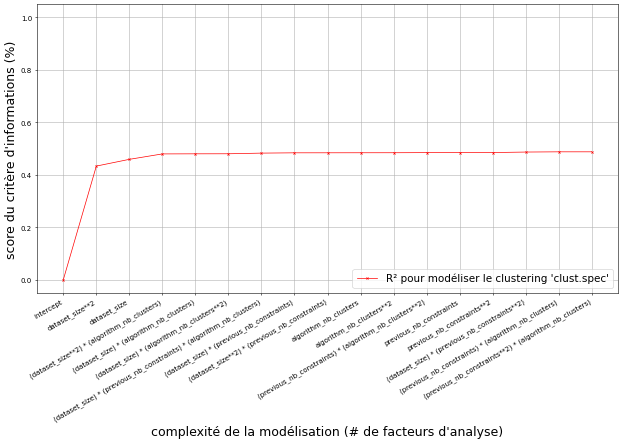

In [206]:
# Compute correlation of factors for clustering.
df_correlation_clustering_spectral_SPEC: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="spectral_SPEC",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_clustering_spectral_SPEC = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_spectral_SPEC,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="spectral_SPEC",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-3clust-spec.png",
    graph_plot_description="R² pour modéliser le clustering 'clust.spec'",
)
df_correlation_clustering_spectral_SPEC

In [218]:
# Compare several GLm models to get the best (lower Deviance, maximum Log-Likelihood)
df_scores_clustering_spec = compare_glm_models(
    df=df_clustering,
    algorithm_name="spectral_SPEC",
    formulas=[
        "time_total ~ 1",
        "time_total ~ 1 + X1POW2",
        "time_total ~ 1 + X1POW2_X3POW1",
        "time_total ~ 1 + X1POW2 + X1POW2_X3POW1",
    ],
)
df_scores_clustering_spec

,formula,degree of freedom,pseudo R² (Cox-Snell),log-likelihood
0,time_total ~ 1,0,2.644757e-09,-82739.188702
1,time_total ~ 1 + X1POW2,1,5.336913e-01,-78840.875769
2,time_total ~ 1 + X1POW2_X3POW1,1,4.223282e-01,-79731.381081
3,time_total ~ 1 + X1POW2 + X1POW2_X3POW1,2,5.637217e-01,-78585.809446


> `clustering.spectral_SPEC ~ 1 + dataset_size**2`

In [215]:
# Fit the model to the data and print results.
best_model_clust_spectral_SPEC = statsmodels.formula.api.glm(
    formula="time_total ~ X1POW2",  # dataset_size**2
    data=df_clustering[df_clustering["algorithm_name"]=="spectral_SPEC"],
)
best_results_clust_spectral_SPEC = best_model_clust_spectral_SPEC.fit()
print(best_results_clust_spectral_SPEC.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             time_total   No. Observations:                13750
Model:                            GLM   Df Residuals:                    13748
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          5597.3
Method:                          IRLS   Log-Likelihood:                -78841.
Date:                Thu, 25 May 2023   Deviance:                   7.6951e+07
Time:                        18:06:21   Pearson chi2:                 7.70e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5337
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0429      1.032     10.698      0.0

In [220]:
# Print the modelization.
print(
    "clustering.spectral.spec ~",
    "{0:.2E}".format(best_results_clust_spectral_SPEC.params["Intercept"]),
    "+ {0:.2E}*{1}".format(best_results_clust_spectral_SPEC.params["X1POW2"], factors_interactions_for_clustering["X1POW2"])
)

clustering.spectral.spec ~ 1.10E+01 + 7.56E-06*dataset_size**2


In [221]:
# Define the interpolation function.
def interpolation_clust_spectral_SPEC(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_clust_spectral_SPEC.params["Intercept"] - best_results_clust_spectral_SPEC.bse["Intercept"])
    res += best_results_clust_spectral_SPEC.params["Intercept"]
    res_high += (best_results_clust_spectral_SPEC.params["Intercept"] + best_results_clust_spectral_SPEC.bse["Intercept"])
    # X1POW2: dataset_size**2.
    res_low += (best_results_clust_spectral_SPEC.params["X1POW2"] - best_results_clust_spectral_SPEC.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_clust_spectral_SPEC.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_clust_spectral_SPEC.params["X1POW2"] + best_results_clust_spectral_SPEC.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.3.7. Print all clustering computation time model.

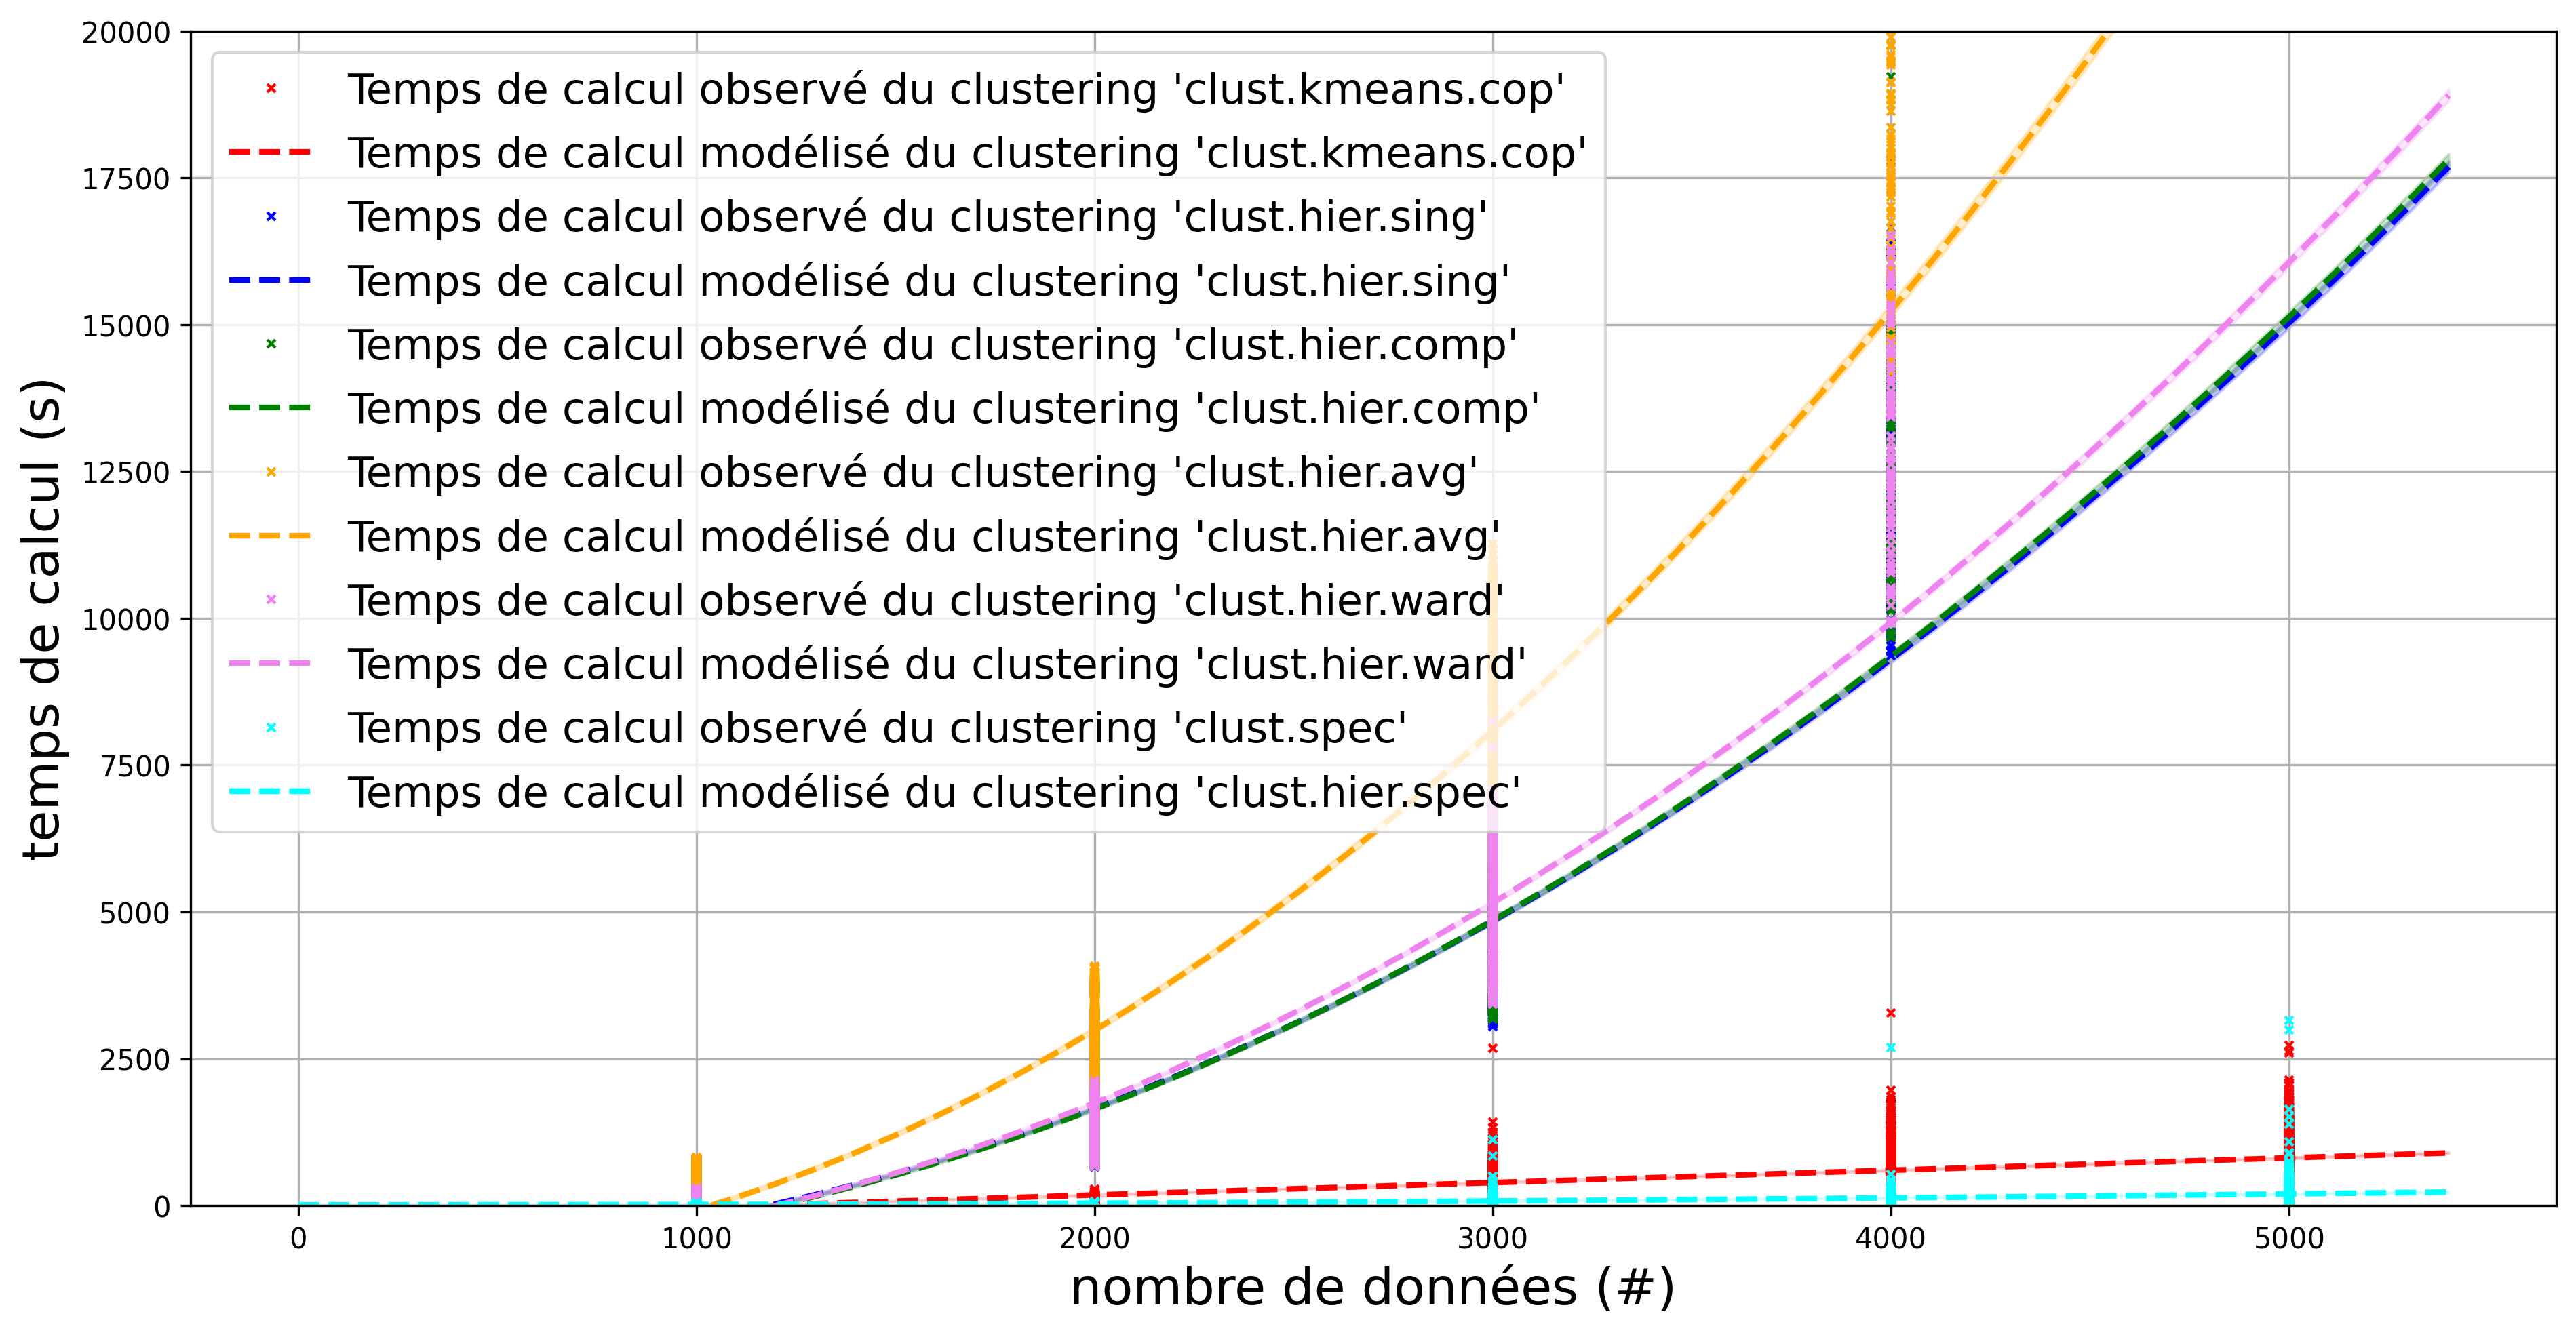

In [222]:
# Create a new figure.
fig_plot_clustering: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_clustering = fig_plot_clustering.gca()

# Plot computation time for kmeans_COP.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="kmeans_COP"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="kmeans_COP"]["time_total"],  # y
    label="Temps de calcul observé du clustering 'clust.kmeans.cop'",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_kmeans_COP(x, y, z)[1]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé du clustering 'clust.kmeans.cop'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
axis_plot_clustering.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_clust_kmeans_COP(x, y, z)[0]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        np.mean([
            interpolation_clust_kmeans_COP(x, y, z)[2]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y2
    color="red",
    alpha=0.2,
)

# Plot computation time for hier_single.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_single"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_single"]["time_total"],  # y
    label="Temps de calcul observé du clustering 'clust.hier.sing'",
    marker="x",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_single(x, y, z)[1]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé du clustering 'clust.hier.sing'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
axis_plot_clustering.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_clust_hier_single(x, y, z)[0]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        np.mean([
            interpolation_clust_hier_single(x, y, z)[2]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y2
    color="blue",
    alpha=0.2,
)

# Plot computation time for hier_complete.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_complete"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_complete"]["time_total"],  # y
    label="Temps de calcul observé du clustering 'clust.hier.comp'",
    marker="x",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_complete(x, y, z)[1]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé du clustering 'clust.hier.comp'",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)
axis_plot_clustering.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_clust_hier_complete(x, y, z)[0]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        np.mean([
            interpolation_clust_hier_complete(x, y, z)[2]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y2
    color="green",
    alpha=0.2,
)

# Plot computation time for hier_average.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_average"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_average"]["time_total"],  # y
    label="Temps de calcul observé du clustering 'clust.hier.avg'",
    marker="x",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_average(x, y, z)[1]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé du clustering 'clust.hier.avg'",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)
axis_plot_clustering.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_clust_hier_average(x, y, z)[0]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        np.mean([
            interpolation_clust_hier_average(x, y, z)[2]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y2
    color="orange",
    alpha=0.2,
)

# Plot computation time for hier_ward.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_ward"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_ward"]["time_total"],  # y
    label="Temps de calcul observé du clustering 'clust.hier.ward'",
    marker="x",
    markerfacecolor="violet",
    markersize=3,
    color="violet",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_ward(x, y, z)[1]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé du clustering 'clust.hier.ward'",
    marker="",
    markerfacecolor="violet",
    markersize=3,
    color="violet",
    linewidth=2,
    linestyle="--",
)
axis_plot_clustering.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_clust_hier_ward(x, y, z)[0]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        np.mean([
            interpolation_clust_hier_ward(x, y, z)[2]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y2
    color="violet",
    alpha=0.2,
)

# Plot computation time for spectral_SPEC.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="spectral_SPEC"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="spectral_SPEC"]["time_total"],  # y
    label="Temps de calcul observé du clustering 'clust.spec'",
    marker="x",
    markerfacecolor="cyan",
    markersize=3,
    color="cyan",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_spectral_SPEC(x, y, z)[1]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé du clustering 'clust.hier.spec'",
    marker="",
    markerfacecolor="cyan",
    markersize=3,
    color="cyan",
    linewidth=2,
    linestyle="--",
)
axis_plot_clustering.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_clust_spectral_SPEC(x, y, z)[0]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y1
    y2=[
        np.mean([
            interpolation_clust_spectral_SPEC(x, y, z)[2]
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],  # y2
    color="cyan",
    alpha=0.2,
)

# Set axis name.
axis_plot_clustering.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_clustering.set_ylabel("temps de calcul (s)", fontsize=18,)
axis_plot_clustering.set_ylim(ymin=0, ymax=20000)

# Plot the legend.
axis_plot_clustering.legend(
    loc="upper left",
    fontsize=15,
)

# Plot the grid.
axis_plot_clustering.grid(True)

# Store the graph.
fig_plot_clustering.savefig(
    "../results/etude-temps-calcul-modelisation-3clust.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

----------

## 2.4. ANALYSIS FOR SAMPLING

> - algorithms: `random`, `in_same`, `farthest`, `closest`
> - factors: `dataset_size`, `previous_nb_constraints`, `previous_nb_clusters`, `algorithm_nb_to_select`

In [ ]:
df_sampling = pd.read_csv("../results/experiments_synthesis_for_sampling.csv", sep=";", index_col=0)
df_sampling["time_total"] = df_sampling["time_total"].str.replace(",", ".").astype(float)
df_sampling.head()

In [ ]:
# Compute interaction of factors for sampling.
factors_interactions_for_sampling, df_sampling = compute_combinations_of_interactions_of_factors(
    df=df_sampling,
    factors=["dataset_size", "previous_nb_constraints", "previous_nb_clusters", "algorithm_nb_to_select"],
    range_of_powers=[0, 1, 2],
    max_power=3,
)
factors_interactions_for_sampling

### 2.4.0. Dertermine if sampling computation time is `algorithm_name` dependant.

In [ ]:
# Fit the model to the data and print results.
model_samp_ALGONAME = statsmodels.formula.api.glm(
    formula="time_total ~ C(algorithm_name)",
    data=df_sampling,
)
results_samp_ALGONAME = model_samp_ALGONAME.fit()
print(results_samp_ALGONAME.summary())

### 2.4.1. Modelize `random` sampling `algorithm_name`.

In [ ]:
# Compute correlation of factors for sampling.
df_correlation_sampling_random: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="random",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_sampling_random = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_random,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="random",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-4samp-rand-full.png",
    graph_plot_description="R² pour modéliser l'échantillonnage 'samp.rand.full'",
)
df_correlation_sampling_random

> `sampling.random ~ 1 + dataset_size**2`

In [ ]:
# Fit the model to the data and print results.
best_model_samp_random = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW2",  # dataset_size**2
    data=df_sampling[df_sampling["algorithm_name"]=="random"],
)
best_results_samp_random = best_model_samp_random.fit()
print(best_results_samp_random.summary())

In [ ]:
# Print the modelization.
print(
    "sampling.rand.full ~",
    "{0:.2E}(+/-{1:.2E})".format(best_results_samp_random.params["Intercept"], best_results_samp_random.bse["Intercept"]),
    "+ {0:.2E}(+/-{1:.2E})*{2}".format(best_results_samp_random.params["X1POW2"], best_results_samp_random.bse["X1POW2"], factors_interactions_for_sampling["X1POW2"])
)

In [ ]:
# Define the interpolation function.
def interpolation_samp_random(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_samp_random.params["Intercept"] - best_results_samp_random.bse["Intercept"])
    res += best_results_samp_random.params["Intercept"]
    res_high += (best_results_samp_random.params["Intercept"] + best_results_samp_random.bse["Intercept"])
    # X1POW2: dataset_size**2.
    res_low += (best_results_samp_random.params["X1POW2"] - best_results_samp_random.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_samp_random.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_samp_random.params["X1POW2"] + best_results_samp_random.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.4.2. Modelize `random_in_same` sampling `algorithm_name`.

In [ ]:
# Compute correlation of factors for sampling.
df_correlation_sampling_random_in_same: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="in_same",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_sampling_random_in_same = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_random_in_same,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="in_same",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-4samp-rand-same.png",
    graph_plot_description="R² pour modéliser l'échantillonnage 'samp.rand.same'",
)
df_correlation_sampling_random_in_same

> `sampling.random_in_same ~ 1 + dataset_size**2`

In [ ]:
# Fit the model to the data and print results.
best_model_samp_random_in_same = statsmodels.formula.api.glm(
    formula="time_total ~ 1 + X1POW2",  # dataset_size**2
    data=df_sampling[df_sampling["algorithm_name"]=="in_same"],
)
best_results_samp_random_in_same = best_model_samp_random_in_same.fit()
print(best_results_samp_random_in_same.summary())

In [ ]:
# Print the modelization.
print(
    "sampling.rand.same ~",
    "{0:.2E}(+/-{1:.2E})".format(best_results_samp_random_in_same.params["Intercept"], best_results_samp_random_in_same.bse["Intercept"]),
    "+ {0:.2E}(+/-{1:.2E})*{2}".format(best_results_samp_random_in_same.params["X1POW2"], best_results_samp_random_in_same.bse["X1POW2"], factors_interactions_for_sampling["X1POW2"])
)

In [ ]:
# Define the interpolation function.
def interpolation_samp_random_in_same(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_samp_random_in_same.params["Intercept"] - best_results_samp_random_in_same.bse["Intercept"])
    res += best_results_samp_random_in_same.params["Intercept"]
    res_high += (best_results_samp_random_in_same.params["Intercept"] + best_results_samp_random_in_same.bse["Intercept"])
    # X1POW2: dataset_size**2.
    res_low += (best_results_samp_random_in_same.params["X1POW2"] - best_results_samp_random_in_same.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_samp_random_in_same.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_samp_random_in_same.params["X1POW2"] + best_results_samp_random_in_same.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.4.3. Modelize `farthest_in_same` sampling `algorithm_name`.

In [ ]:
# Compute correlation of factors for sampling.
df_correlation_sampling_farthest_in_same: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="farthest",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_sampling_farthest_in_same = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_farthest_in_same,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="farthest",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-4samp-farthest-same.png",
    graph_plot_description="R² pour modéliser l'échantillonnage 'samp.farthest.same'",
)
df_correlation_sampling_farthest_in_same

> `sampling.farthest_in_same ~ dataset_size**2`

In [ ]:
# Fit the model to the data and print results.
best_model_samp_farthest_in_same = statsmodels.formula.api.glm(
    formula="time_total ~ X1POW2",  # dataset_size**2
    data=df_sampling[df_sampling["algorithm_name"]=="farthest"],
)
best_results_samp_farthest_in_same = best_model_samp_farthest_in_same.fit()
print(best_results_samp_farthest_in_same.summary())

In [ ]:
# Print the modelization.
print(
    "sampling.farthest.same ~",
    "{0:.2E}(+/-{1:.2E})".format(best_results_samp_farthest_in_same.params["Intercept"], best_results_samp_farthest_in_same.bse["Intercept"]),
    "+ {0:.2E}(+/-{1:.2E})*{2}".format(best_results_samp_farthest_in_same.params["X1POW2"], best_results_samp_farthest_in_same.bse["X1POW2"], factors_interactions_for_sampling["X1POW2"])
)

In [ ]:
# Define the interpolation function.
def interpolation_samp_farthest_in_same(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_samp_farthest_in_same.params["Intercept"] - best_results_samp_farthest_in_same.bse["Intercept"])
    res += best_results_samp_farthest_in_same.params["Intercept"]
    res_high += (best_results_samp_farthest_in_same.params["Intercept"] + best_results_samp_farthest_in_same.bse["Intercept"])
    # X1POW2: dataset_size**2.
    res_low += (best_results_samp_farthest_in_same.params["X1POW2"] - best_results_samp_farthest_in_same.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_samp_farthest_in_same.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_samp_farthest_in_same.params["X1POW2"] + best_results_samp_farthest_in_same.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.4.4. Modelize `closest_in_different` sampling `algorithm_name`.

In [ ]:
# Compute correlation of factors for sampling.
df_correlation_sampling_closest_in_different: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="closest",
)
# Print evolution of information score per model complexity.
information_score_evolution_for_sampling_closest_in_different = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_closest_in_different,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="closest",
    graph_filepath="../results/etude-temps-calcul-analyse-facteurs-4samp-closest-diff.png",
    graph_plot_description="R² pour modéliser l'échantillonnage 'samp.closest.diff'",
)
df_correlation_sampling_closest_in_different

> `sampling.closest_in_different ~ dataset_size**2`

In [ ]:
# Fit the model to the data and print results.
best_model_samp_closest_in_different = statsmodels.formula.api.glm(
    formula="time_total ~ X1POW2",  # dataset_size**2
    data=df_sampling[df_sampling["algorithm_name"]=="closest"],
)
best_results_samp_closest_in_different = best_model_samp_closest_in_different.fit()
print(best_results_samp_closest_in_different.summary())

In [ ]:
# Print the modelization.
print(
    "sampling.closest.diff ~",
    "{0:.2E}(+/-{1:.2E})".format(best_results_samp_closest_in_different.params["Intercept"], best_results_samp_closest_in_different.bse["Intercept"]),
    "+ {0:.2E}(+/-{1:.2E})*{2}".format(best_results_samp_closest_in_different.params["X1POW2"], best_results_samp_closest_in_different.bse["X1POW2"], factors_interactions_for_sampling["X1POW2"])
)

In [ ]:
# Define the interpolation function.
def interpolation_samp_closest_in_different(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (best_results_samp_closest_in_different.params["Intercept"] - best_results_samp_closest_in_different.bse["Intercept"])
    res += best_results_samp_closest_in_different.params["Intercept"]
    res_high += (best_results_samp_closest_in_different.params["Intercept"] + best_results_samp_closest_in_different.bse["Intercept"])
    # X1POW2: dataset_size**2.
    res_low += (best_results_samp_closest_in_different.params["X1POW2"] - best_results_samp_closest_in_different.bse["X1POW2"]) * np.power(dataset_size,2)
    res += best_results_samp_closest_in_different.params["X1POW2"] * np.power(dataset_size,2)
    res_high += (best_results_samp_closest_in_different.params["X1POW2"] + best_results_samp_closest_in_different.bse["X1POW2"]) * np.power(dataset_size,2)
    # Return.
    return res_low, res, res_high

### 2.4.5. Print all sampling computation time model.

In [ ]:
# Create a new figure.
fig_plot_sampling: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_sampling = fig_plot_sampling.gca()

# Plot computation time for random.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="random"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="random"]["time_total"],  # y
    label="Temps de calcul observé de l'échantillonnage 'samp.random.full'",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x1
    [
        np.mean([
            interpolation_samp_random(x1, x2, x3, x4)[0]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé de l'échantillonnage 'samp.random.full'",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)
axis_plot_sampling.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_samp_random(x1, x2, x3, x4)[1]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    y2=[
        np.mean([
            interpolation_samp_random(x1, x2, x3, x4)[2]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    color="red",
    alpha=0.2,
)

# Plot computation time for random_in_same.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="in_same"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="in_same"]["time_total"],  # y
    label="Temps de calcul observé de l'échantillonnage 'samp.random.same'",
    marker="x",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_samp_random_in_same(x1, x2, x3, x4)[0]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé de l'échantillonnage 'samp.random.same'",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)
axis_plot_sampling.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_samp_random_in_same(x1, x2, x3, x4)[1]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    y2=[
        np.mean([
            interpolation_samp_random_in_same(x1, x2, x3, x4)[2]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    color="blue",
    alpha=0.2,
)

# Plot computation time for farthest_in_same.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="farthest"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="farthest"]["time_total"],  # y
    label="Temps de calcul observé de l'échantillonnage 'samp.farthest.same'",
    marker="x",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_samp_farthest_in_same(x1, x2, x3, x4)[0]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé de l'échantillonnage 'samp.farthest.same'",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)
axis_plot_sampling.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_samp_farthest_in_same(x1, x2, x3, x4)[1]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    y2=[
        np.mean([
            interpolation_samp_farthest_in_same(x1, x2, x3, x4)[2]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    color="green",
    alpha=0.2,
)

# Plot computation time for closest_in_different.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="closest"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="closest"]["time_total"],  # y
    label="Temps de calcul observé de l'échantillonnage 'samp.closest.diff'",
    marker="x",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_samp_closest_in_different(x1, x2, x3, x4)[0]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="Temps de calcul modélisé de l'échantillonnage 'samp.closest.diff'",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)
axis_plot_sampling.fill_between(
    x=range(0, 5500, 100),  # x
    y1=[
        np.mean([
            interpolation_samp_closest_in_different(x1, x2, x3, x4)[1]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    y2=[
        np.mean([
            interpolation_samp_closest_in_different(x1, x2, x3, x4)[2]
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    color="orange",
    alpha=0.2,
)

# Set axis name.
axis_plot_sampling.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_sampling.set_ylabel("temps de calcul (s)", fontsize=18,)

# Plot the legend.
axis_plot_sampling.legend(
    loc="upper left",
    fontsize=15,
)

# Plot the grid.
axis_plot_sampling.grid(True)

# Store the graph.
fig_plot_sampling.savefig(
    "../results/etude-temps-calcul-modelisation-4samp.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)